In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [1]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

import warnings
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from joblib import dump, load
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split


In [3]:
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=3, linewidth=120)

# The Purpose Study :

the purpose of this study is two-fold: 

1. to predict targert values, i.e. Ic_Norm using regression algorithms.
2. to determine the set of features which have more importance on predicting target values during the regression process.

### Metrics

###### Mean Absolute Error (MAE):

$mae = \frac{1}{N} \sum_{i=1}^{N} |y_{i} - y^{'}_{i}|$

- MAE measures the average magnitude of the errors in a set of predictions, without considering their direction.

    - Note: all individual differences have equal weight

###### Root mean squared error (RMSE):

$ rmse = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_{i} - y^{'}_{i})^{2}} $

- RMSE is the square root of the average of squared differences between prediction and actual observation.
    - It assigns more weight to large errors becuase of squaring
    - Not easy to interpret

###### Mean Relative Absolute Error (MRAE):

- MRAE is a weighted measure of prediction accuracy and it assigns weights to errors.

$mrae = \frac{1}{N} \sum_{i=1}^{N} |\frac{y_{i} - y^{'}_{i}}{y_{i}}|$

Ref: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

- We consider the MRAE as our main metric to evaluat the performance of algorithms


###### coefficient of determination ($R^2$ )

The coefficient $R^2$ is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a $R^2$ score of 0.0.



### Conclusion over metrics

- Although all the aforementioned metrics would be suitable for some tasks, but for this task, we will use MRAE and R^2 as the final metrics to evaluate the performance of regression models.



In [4]:
def mae(y_trues, y_preds):
    return np.mean(np.abs(y_trues-y_preds))

def rmse(y_trues, y_preds):
    return np.sqrt(np.mean(np.power(y_trues-y_preds, 2)))

def mrae(y_trues, y_preds):
    return np.mean(np.abs(np.divide(y_trues -y_preds, y_trues)))

### Feature importance:

There exist several methods to determine the importance of features as follows.

1. **The coefficients of linear regression:**

    - Once the LR model is fitted, the weights can be used to interpret the importance of the features.

    - cons: over-simplistic.


2. **The weights of DNN**: 

    - Similarly, once a DNN model is trained the weights can be used to interpret the importance of features. Noteworthy to add that, interpreting those weights is a tricky business

    - Cons: sometimes a DNN does not a proper choice for the task i.e we cannot train it properly as it is also the case for us (when we do not cut the tails of the data points). Moreover, it is hard to interpret. 


3. **Gini importance(or mean decrease in impurity) mechanism:** 

    - Gini importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature. 
    
    In other words, the mean decrease in impurity importance of a feature is computed by measuring how effective the feature is at reducing uncertainty (classifiers) or variance (regressors) when creating decision trees within RFs.

    - Cons: impurity-based feature importances can be misleading for high cardinality features. (It tends to inflate the importance of continuous or high-cardinality categorical variables). 
    

4. **Permutation importance mechanism:** First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted and the metric is evaluated again. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

    - Cons: computationally, more expensive than Gini importance, but still more reliable. Moreover, highly correlated features could yield biased estimations or overestimations of the importance of features (Strobl et al. (2007) , Nicodemus et al. (2010)).


5. **Drop-column importance:**

    Itetate over all features, drop them one by one, and trian an estimator and compute the importance, and choose those which give higher R^2 score.
    
    - Cons: computationally, very expensive and sometimes not applicable. And moreover, the combination of feaures are not considered.


### Conclusion over feature importance methods:

- Since, mostly, in the litrature, using permutation importance is recommended more than other above-mentioned methods we will use this method.


### Load data set and split it

In [5]:
pld_complete_range = pd.read_csv("../../data/pld_complete_range.csv", index_col=False)
pld_complete = catalog.load('pld_complete').dropna().sort_values('pos', ascending=True)

2020-11-27 15:59:35,786 - kedro.io.data_catalog - INFO - Loading data from `pld_complete` (ParquetDataSet)...
2020-11-27 15:59:35,994 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


In [6]:
pld_complete_range.head()

,median_Voltage_HSR_V_1025,median_Voltage_HSR_V_1027,median_Voltage_HSR_V_1030,median_Voltage_HSL_V_1025,median_Voltage_HSL_V_1027,median_Voltage_HSL_V_1030,median_Voltage_HF_V_1025,median_Voltage_HF_V_1027,median_Voltage_HF_V_1030,median_Voltage_HC_V_1025,...,std_Sigma_1030,pos,Speed,X FWHM,Y FWHM,R FWHM,Coolness,Coolness_neg,Ic,Ic_norm
0,0.129479,0.177414,0.005142,0.69562,-0.256257,-0.015406,-0.009215,-0.072807,-0.021102,0.057123,...,-0.390667,-0.501695,0.009841,0.039589,0.067470,0.015697,0.053006,-0.086369,496.2,1.767913
1,0.110059,0.340245,0.005142,0.69562,-0.321465,-0.015406,-0.009215,-0.173901,-0.021102,0.050178,...,-0.390667,-0.501652,-0.005266,0.039589,0.067470,0.015697,0.053006,-0.086369,494.7,1.762568
2,0.119769,0.340245,0.005142,0.69562,-0.321465,-0.015406,-0.007363,-0.173901,-0.021102,0.057123,...,-0.390667,-0.501646,-0.007197,0.039589,0.067470,0.015697,0.053006,-0.086369,494.2,1.760787
3,0.110059,0.348139,0.005142,0.69562,-0.322354,-0.015406,-0.009215,-0.218270,-0.021102,0.057123,...,-0.390667,-0.501635,-0.010946,0.039589,0.067470,0.015697,0.053006,-0.086369,495.5,1.765419
4,0.110059,0.264593,0.005142,0.69562,-0.305820,-0.015406,-0.009215,-0.129533,-0.021102,0.057123,...,-0.390667,-0.501619,-0.017147,0.042682,0.069442,0.017956,0.051965,-0.084836,497.9,1.773168


In [7]:
x_r = pld_complete_range.loc[:, ~pld_complete_range.columns.isin(['Ic', 'Ic_norm', 'pos'])].to_numpy()
y = pld_complete_range['Ic_norm'].to_numpy()
pos = pld_complete_range['pos'].to_numpy()
x_r.shape, y.shape, pos.shape

((18561, 376), (18561,), (18561,))

### Spliting data set into train and test sets

In [8]:
x_r_train, x_r_test, y_train, y_test = train_test_split(x_r, y,
                                                        test_size=0.25,
                                                        random_state=43,)

x_r_train.shape, x_r_test.shape, y_train.shape, y_test.shape

((13920, 376), (4641, 376), (13920,), (4641,))

## Prediction as Regression Problem

Since, previously, we have scrutinized four regression methods and their performances. As a result, I will use Random Forest regressor (RF) and Gradient Boosting  Regressor with the least-square loss function (GBR-LS) for this task.

Noteworthy to add that the data are standardized with range standardized.


### Random Forest Regression

In [ ]:
%%time
mae_rf, rmse_rf, mrae_rf, r2_score_rf = [], [], [], []
n_repeats = 5

for repeat in range(n_repeats):
    
    print("repeat:", repeat)
    
    rf_reg = RandomForestRegressor(n_estimators=100, 
                                   n_jobs = 3, 
                                   criterion='mse', 
                                   verbose=0)
    
    rf_reg.fit(x_r_train, y_train)
    y_hat_rf = rf_reg.predict(x_r_test)
    rf_reg_feature_importance = rf_reg.feature_importances_  # Gini Index/impurity
    
    
    r2_score_rf.append(rf_reg.score(x_r_test, y_test))
    
    mae_rf.append(mae(y_trues=y_test, y_preds=y_hat_rf))
    rmse_rf.append(rmse(y_trues=y_test, y_preds=y_hat_rf))
    mrae_rf.append(mrae(y_trues=y_test, y_preds=y_hat_rf))
    

In [ ]:
r2_score_rf = np.asarray(r2_score_rf)
mae_rf = np.asarray(mae_rf)
rmse_rf = np.asarray(rmse_rf)
mrae_rf = np.asarray(mrae_rf)



print("RF Reg.:  Mean  std", "\n"
      "R^2    : %.3f" % r2_score_rf.mean(),  "%.3f" %  r2_score_rf.std(), "\n"
      "MAE    : %.3f" % mae_rf.mean(), "%.3f" %  mae_rf.std(), "\n"
      "RMSE   : %.3f" % rmse_rf.mean(), "%.3f" %  rmse_rf.std(),"\n"
      "MRAE   : %.3f" % mrae_rf.mean(), "%.3f" %  mrae_rf.std())

- rather high (and good) R^2 score (coefficient of determinations) with almost zero std.
- low error w.r.t all the metrics under consideration. Note the zero stds.

#### Saving RF-ref model.

In [ ]:
# dump(rf_reg, "../../models/rf_reg_ic_norm.joblib")

### Gradient Boosting Regression with Least Square Loss Function 

In [ ]:
%%time 

r2_score_gbr_ls, mae_gbr_ls, rmse_gbr_ls, mrae_gbr_ls = [], [], [], []
n_repeats = 5

for repeat in range(n_repeats):
    
    print("repeat:", repeat)
    
    gbr_ls = GradientBoostingRegressor(loss='ls', verbose=0,)
    gbr_ls.fit(x_r_train, y_train)
    y_hat_gbr_ls = gbr_ls.predict(x_r_test)
    gbr_ls_feature_importance = gbr_ls.feature_importances_
    
    
    r2_score_gbr_ls.append(gbr_ls.score(x_r_test, y_test))

    mae_gbr_ls.append(mae(y_trues=y_test, y_preds=y_hat_gbr_ls))
    rmse_gbr_ls.append(rmse(y_trues=y_test, y_preds=y_hat_gbr_ls))
    mrae_gbr_ls.append(mrae(y_trues=y_test, y_preds=y_hat_gbr_ls))


In [ ]:
r2_score_gbr_ls = np.asarray(r2_score_gbr_ls)
mae_gbr_ls = np.asarray(mae_gbr_ls)
rmse_gbr_ls = np.asarray(rmse_gbr_ls)
mrae_gbr_ls = np.asarray(mrae_gbr_ls)


print("GBR-LS Reg.:  Mean  std", "\n"
      "R^2        : %.3f" % r2_score_gbr_ls.mean(),  "%.3f" %  r2_score_gbr_ls.std(), "\n"
      "MAE        : %.3f" % mae_gbr_ls.mean(), "%.3f" %  mae_gbr_ls.std(), "\n"
      "RMSE       : %.3f" % rmse_gbr_ls.mean(), "%.3f" %  rmse_gbr_ls.std(),"\n"
      "MRAE       : %.3f" % mrae_gbr_ls.mean(), "%.3f" %  mrae_gbr_ls.std())

- moderately high R^2 score (coefficient of determinations) with zero std.
- very low error w.r.t all the metrics under consideration. Note the zero stds.

#### Saving GBR-LS model 

In [ ]:
# dump(gbr_ls, "../../models/gbr_ls.joblib")

### Conclusion over Regression Algorithms





Note: Although, I briefly reviewed the the impact of some of the hyper-parameters but I did not provide information about it because of the time limit.


- Except for $R^2$ of Linear Reg. the rest of the obtained results are quite good.

In [ ]:
print(" \t   RF Reg. ", "   GBR-LS" "\n"
    "Metrics:  Mean  std ",  "Mean  std" "\n"
      "R^2    : %.3f" % r2_score_rf.mean(),  "%.3f" %  r2_score_rf.std(),
      "%.3f" % r2_score_gbr_ls.mean(),  "%.3f" %  r2_score_gbr_ls.std(), "\n"
      
      "MAE    : %.3f" % mae_rf.mean(), "%.3f" %  mae_rf.std(), 
      "%.3f" % mae_gbr_ls.mean(), "%.3f" %  mae_gbr_ls.std(), "\n"
      
      "RMSE   : %.3f" % rmse_gbr_ls.mean(), "%.3f" %  rmse_gbr_ls.std(),
      "%.3f" % rmse_rf.mean(), "%.3f" %  rmse_rf.std(), "\n"
      
      "MRAE   : %.3f" % mrae_rf.mean(), "%.3f" %  mrae_rf.std(),
      "%.3f" % mrae_gbr_ls.mean(), "%.3f" %  mrae_gbr_ls.std())


- Both algorithms obtain acceptable R^2 score. Yet the performance of RF is better. 
- Both algorithms obtain low errors (as it was previously observed).
- Because of better R^2 score we will use RF for production 

## Feature Importance Using Permutation Method:



######  Important Features w.r.t. Random Forest:


In [51]:
%%time
rf_reg_permute = RandomForestRegressor(n_estimators=100, 
                                       n_jobs = 3, 
                                       criterion='mse', 
                                       verbose=0)
    
rf_reg_permute.fit(x_r_train, y_train)


rf_reg_feature_importance_permute = permutation_importance(rf_reg_permute,
                                                           x_r_test, y_test, 
                                                           n_repeats=5, 
                                                           random_state=0)


CPU times: user 18min 4s, sys: 14.3 s, total: 18min 18s
Wall time: 6min 38s


In [52]:
# dump(rf_reg_feature_importance_permute, "../../models/rf_reg_perm_imp.job/lib")

['../../models/rf_reg_perm_imp.joblib']

In [53]:
# rf_reg_feature_importance_permute = load("../../models/rf_reg_perm_imp.joblib")

In [58]:
# RF Reg. Permutation method:
thr = 0.01
idx_important_features_rf_permute = \
np.asarray(list(set(np.where(rf_reg_feature_importance_permute['importances_mean']>=thr)[0]).intersection(
    set(np.where(rf_reg_feature_importance_permute['importances_std']<=0.01)[0]))))

name_important_features_rf_permute = list(pld_complete_range.columns[idx_important_features_rf_permute])
values_rf_feature_importance_permute = \
rf_reg_feature_importance_permute['importances_mean'][idx_important_features_rf_permute].reshape(1, -1)



idx_rf_permute = np.argsort(values_rf_feature_importance_permute)[0][::-1].tolist()

print("Important Features w.r.t Random Forest Reg.:",)
for i in idx_rf_permute:
    print("%.3f" % values_rf_feature_importance_permute[0][i], name_important_features_rf_permute[i], )


Important Features w.r.t Random Forest Reg.:
0.082 mean_Temp_HSL_C_1030
0.081 Y FWHM
0.055 mean_Right_Clatch_prc_1025
0.042 Coolness
0.020 mean_Voltage_HF_V_1025
0.016 Speed
0.014 mean_Current_HF_A_1025
0.013 R FWHM
0.012 mean_Power_HF_W_1025
0.010 median_Temp_HSL_C_1030


######  Important Features w.r.t. Gradient Boosting with - Least Square Loss:


In [48]:
%%time
gbr_ls_permute = GradientBoostingRegressor(loss='ls', verbose=0,)
gbr_ls_permute.fit(x_r_train, y_train)


gbr_ls_reg_feature_importance_permute = permutation_importance(gbr_ls_permute,
                                                               x_r_test, y_test, 
                                                               n_repeats=5, 
                                                               random_state=0)

CPU times: user 2min 49s, sys: 342 ms, total: 2min 50s
Wall time: 2min 50s


In [49]:
# dump(gbr_ls_reg_feature_importance_permute, "../../models/gbr_ls_reg_perm_imp.joblib")

['../../models/gbr_ls_reg_perm_imp.joblib']

In [50]:
# gbr_ls_reg_feature_importance_permute = load("../../models/gbr_ls_reg_perm_imp.joblib")

In [60]:
# GBR-LS Reg. Permutation method:
thr = 0.01
idx_important_features_gbr_ls_permute = \
np.asarray(list(set(np.where(gbr_ls_reg_feature_importance_permute['importances_mean']>=thr)[0]).intersection(
    set(np.where(gbr_ls_reg_feature_importance_permute['importances_std']<=0.01)[0]))))

name_important_features_gbr_ls_permute = list(pld_complete_range.columns[idx_important_features_gbr_ls_permute])
values_gbr_ls_feature_importance_permute = \
gbr_ls_reg_feature_importance_permute['importances_mean'][idx_important_features_gbr_ls_permute].reshape(1, -1)


idx_gbr_ls_permute = np.argsort(values_gbr_ls_feature_importance_permute)[0][::-1].tolist()

print("Important Features w.r.t GBR-LS:",)
for i in idx_gbr_ls_permute:
    print("%.3f" % values_gbr_ls_feature_importance_permute[0][i], 
          name_important_features_gbr_ls_permute[i])


Important Features w.r.t GBR-LS:
0.136 mean_Right_Clatch_prc_1025
0.113 median_Temp_HF_C_1025
0.034 Speed
0.028 Coolness
0.028 median_Left_Clatch_prc_1030
0.024 Y FWHM
0.021 mean_Temp_HSL_C_1030
0.017 mean_Temp_HSL_C_1025
0.016 X FWHM
0.014 median_Voltage_HF_V_1025


## Feature Importance Using Gini Impurity Method:

Note: In the case you have saved the models and you don't want to retrain them, you can uncomment the three following cells below

In [12]:
# rf_reg = load("../../models/rf_reg_ic_norm.joblib")
# gbr_ls = load("../../models/gbr_ls_ic_norm.joblib")

In [13]:
# y_hat_rf = rf_reg.predict(x_r_test)
# y_hat_gbr_ls = gbr_ls.predict(x_r_test)

In [14]:
# rf_reg_feature_importance = rf_reg.feature_importances_
# gbr_ls_feature_importance = gbr_ls.feature_importances_


In [24]:
# RF
thr = 0.005
idx_important_features_rf = np.where(rf_reg_feature_importance>=thr) 

name_important_features_rf = list(pld_complete_range.columns[idx_important_features_rf])
values_rf_feature_importance = \
rf_reg_feature_importance[np.where(rf_reg_feature_importance>=thr)].reshape(1, -1)



In [25]:
# GDB-LS
thr = 0.01

idx_important_features_gbr_ls = np.where(gbr_ls_feature_importance>=thr)
name_important_features_gbr_ls = list(pld_complete_range.columns[idx_important_features_gbr_ls])
values_gbr_ls_feature_importance = \
gbr_ls_feature_importance[np.where(gbr_ls_feature_importance>=thr)].reshape(1, -1)



######  Important Features w.r.t. Random Forest:


In [17]:
idx_rf = np.argsort(values_rf_feature_importance)[0][::-1].tolist()

print("Important Features w.r.t Random Forest Reg.:",)
for i in idx_rf:
    print("%.3f" % values_rf_feature_importance[0][i], name_important_features_rf[i], )

Important Features w.r.t Random Forest Reg.:
0.432 median_Temp_HF_C_1025
0.041 mean_Temp_HSL_C_1030
0.036 mean_Right_Clatch_prc_1025
0.027 Y FWHM
0.019 Coolness
0.014 mean_Voltage_HF_V_1025
0.010 mean_Power_HF_W_1025
0.009 mean_Voltage_HSL_V_1027
0.009 R FWHM
0.006 X FWHM
0.006 mean_Current_HF_A_1025
0.006 median_Right_Tension_n_1025
0.006 Speed


######  Important Features w.r.t. Gradient Boosting with - Least Square Loss:


In [18]:
idx_gbr_ls = np.argsort(values_gbr_ls_feature_importance)[0][::-1].tolist()

print("Important Features w.r.t GDBoost-LS Reg.:",)
for i in idx_gbr_ls:
    print("%.3f" % values_gbr_ls_feature_importance[0][i], name_important_features_gbr_ls[i],)
    

Important Features w.r.t GDBoost-LS Reg.:
0.394 median_Temp_HF_C_1025
0.177 mean_Right_Clatch_prc_1025
0.061 mean_Temp_HSL_C_1025
0.037 mean_Temp_HSL_C_1030
0.035 Y FWHM
0.029 X FWHM
0.022 Coolness
0.021 mean_Temp_HF_C_1025
0.015 Speed
0.012 mean_Voltage_HSL_V_1027
0.011 mean_Power_HF_W_1025


# Comparing the results of Permutations and Gini Index on top5 features


|Importance (descending) | Value | RF-Perm: Name  |  Value | GBR-Ls-Perm:Name | Value | RF-Gini: Name | Value | GBR-Ls-Gini:Name |
| --- | --- | --- |---| ---| --- | --- | --- | --- |
| 1 | 0.082 | median_Temp_HF_C_1025 | 0.136 | mean_Right_Clatch_prc_1025 | 0.432 | median_Temp_HF_C_1025 | 0.394 | median_Temp_HF_C_1025 |
| 2 | 0.081 | Y FWHM | 0.113 | median_Temp_HF_C_1025 | 0.176 | mean_Temp_HSL_C_1030  |  0.177 | mean_Right_Clatch_prc_1025 |
| 3 | 0.055 | mean_Right_Clatch_prc_1025 | 0.034 | Speed | 0.036 | mean_Right_Clatch_prc_1025 | 0.061 | mean_Temp_HSL_C_1025 |
| 4  | 0.042 | Coolness|0.028 | Coolness | 0.027 | Y FWHM | 0.037 | mean_Temp_HSL_C_1030 |
| 5  | 0.020 | mean_Voltage_HF_V_1025 | 0.028 | median_Left_Clatch_prc_1030 | 






#### Conlusion over the table:


- **median_Temp_HF_C_1025:** three times as the most important feature and once as the second most important feature

- **Y FWHM:** 2nd by RF-Perm, 6th by GBR-Perm, 4th by RF-Gini, 5th by GBR-Gini

- **mean_Temp_HSL_C_1030:** 3rd by RF-Perm and 2nd by RF-Gini,  8th by GBR-Perm, 4th by GBR-Gini

- ...


###### Old Data set 

|Importance (descending) | RF-Perm: Name | Value | GBR-Ls-Perm:Name | Value | RF-Gini: Name | Value | GBR-Ls-Gini:Name | Value | 
| --- | --- | --- |---| ---| --- | --- | --- | --- |
| 1 | mean_Temp_HB_C_1025 | 0.362 | median_Power_HF_W_1025 | 0.249|median_Power_HF_W_1025 | 0.432 | median_Power_HF_W_1025 | 0.763 |  
| 2 | median_Power_HF_W_1025 | 0.137 | mean_Temp_HB_C_1025 | 0.132| median_Voltage_HF_V_1025 | 0.200 | median_Temp_HSL_C_1027 | 0.097|
| 3 | median_Temp_HF_C_1025 | 0.116 | mean_Temp_HB_C_1027 | 0.116 |  median_Temp_HSL_C_1027 | 0.144 | mean_Temp_HB_C_1027 | 0.038 |
| 4 | median_Voltage_HF_V_1025 | 0.040 | std_Power_HC_W_1027 | 0.038 |mean_Temp_HB_C_1025 | 0.084 | mean_Temp_HB_C_1025 | 0.034 | 
| 5 | mean_HV_1030 | 0.015 | mean_Right_Clatch_prc_1025 | 0.030 | median_Temp_HF_C_1025 | 0.014 | mean_Right_Clatch_prc_1025 | 0.010 |
|6 | mean_Power_HSL_W_1025 | 0.012 | mean_Voltage_HC_V_1025 | 0.021 |


# Gini Index: visualization of relation between important features and target values 

In [19]:
pld_complete_range_noICs_noPos = pld_complete_range.loc[:, ~pld_complete_range.columns.isin(['Ic', 'Ic_norm', 'pos'])]
features_names = list(pld_complete_range_noICs_noPos.columns)
lb = 0  # to filter the demonstrations-- index of lower bound >> lowest = 0
ub = 4703  # to filter the demonstrations-- index of upper bound >> highest = n_samples (4703)

### Random Forest 

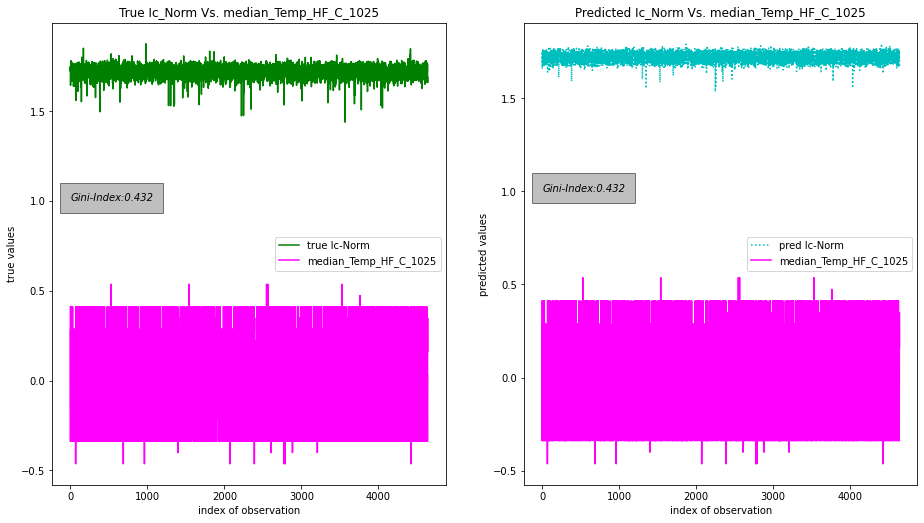

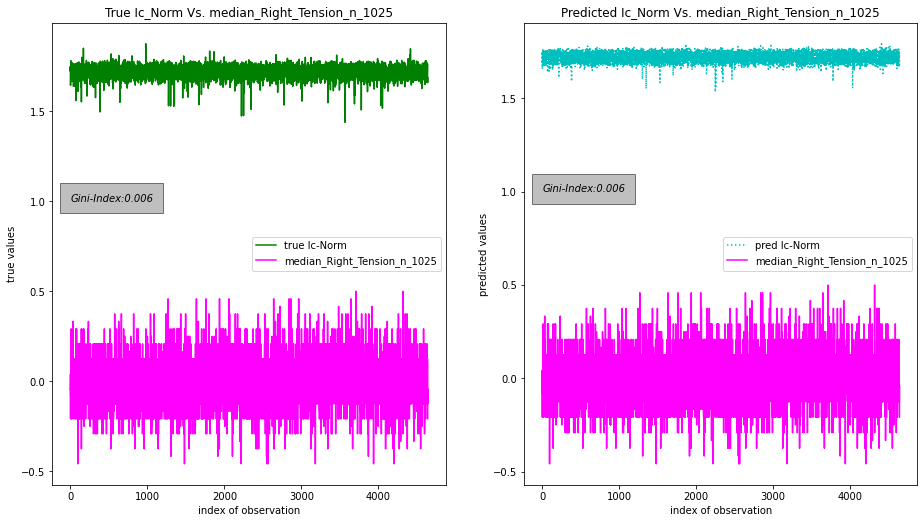

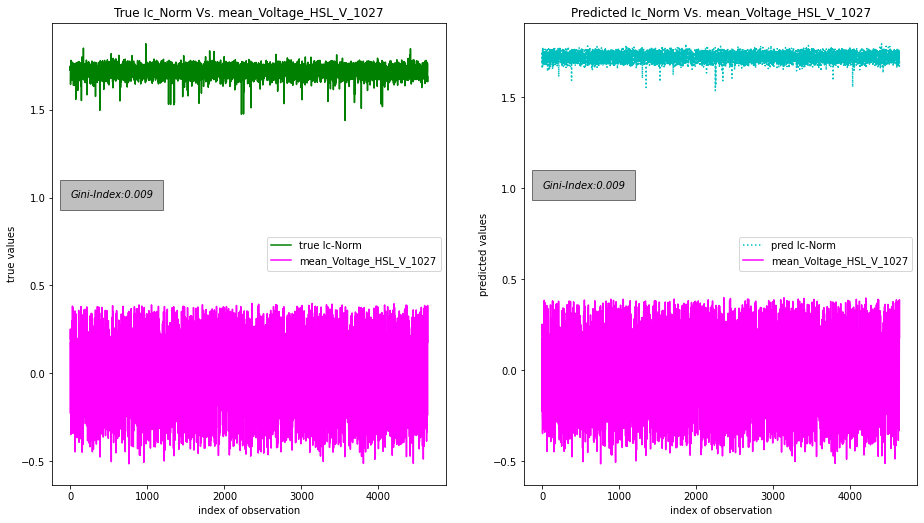

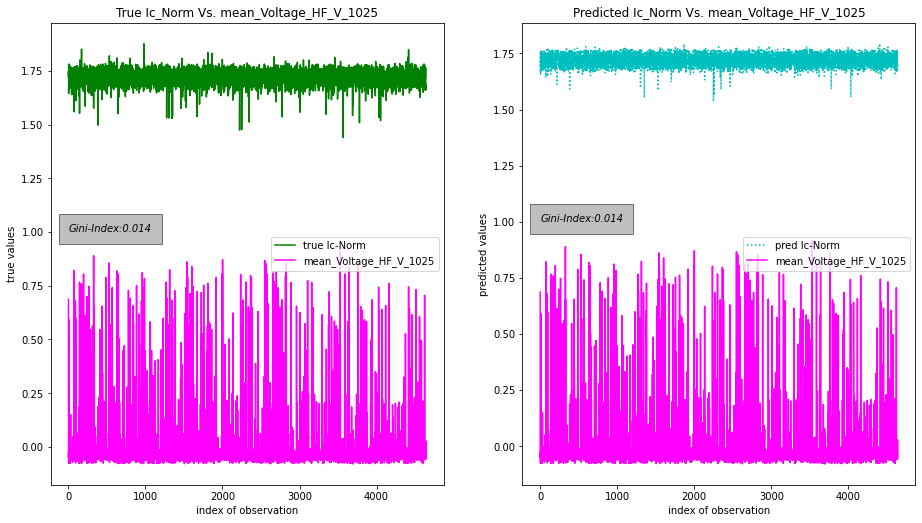

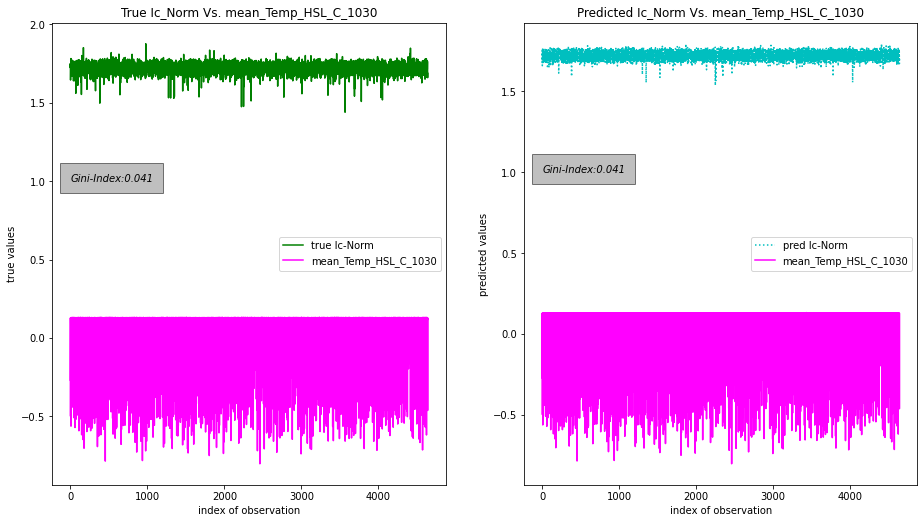

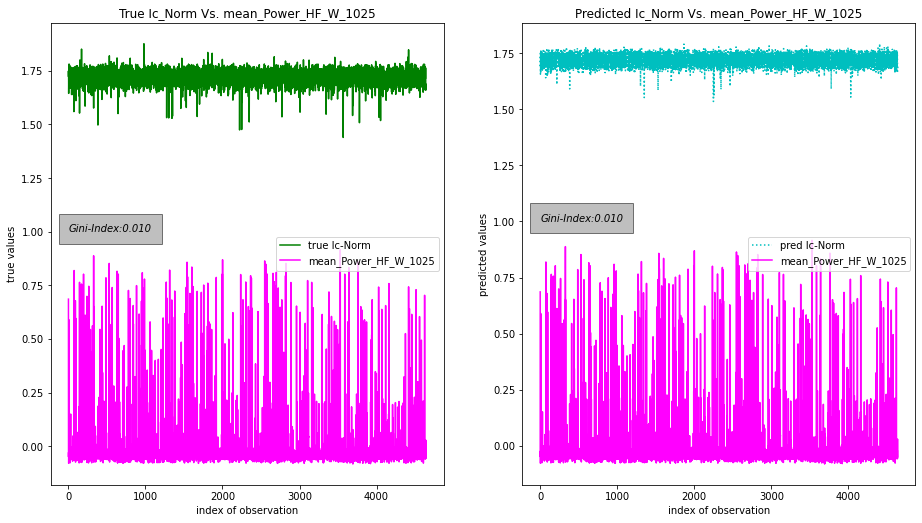

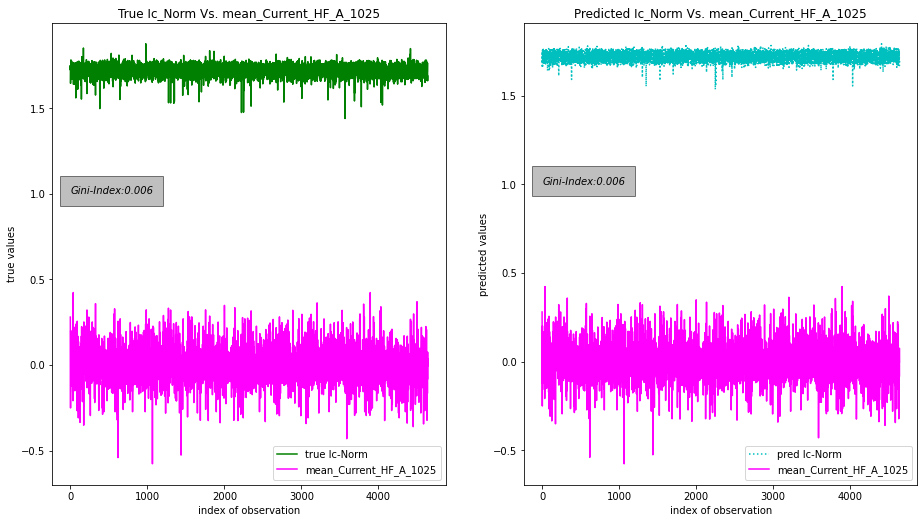

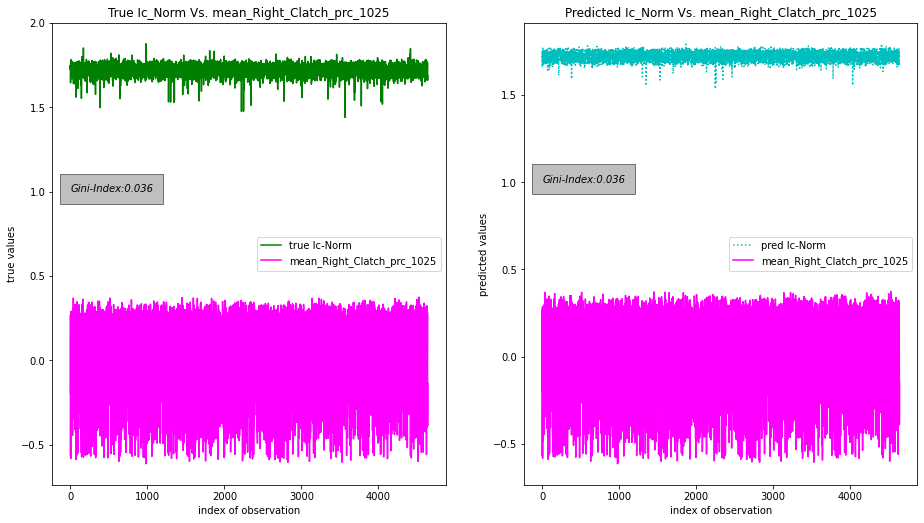

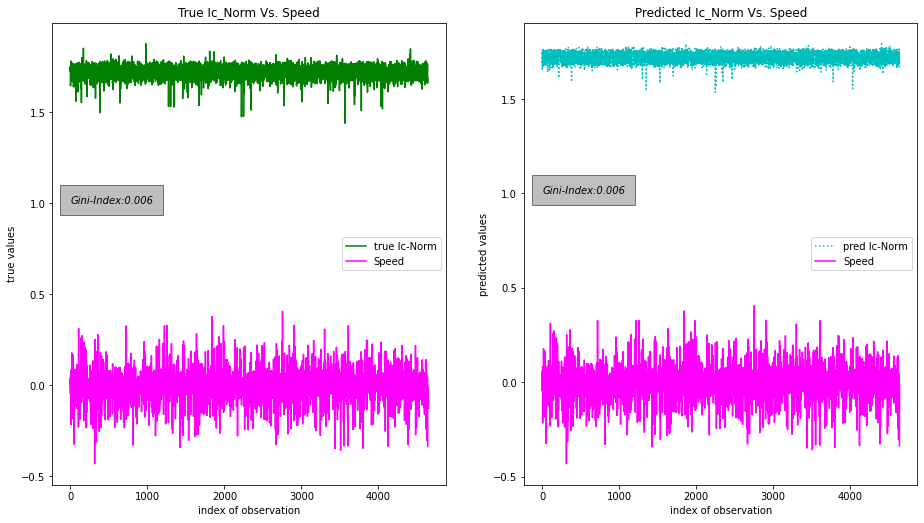

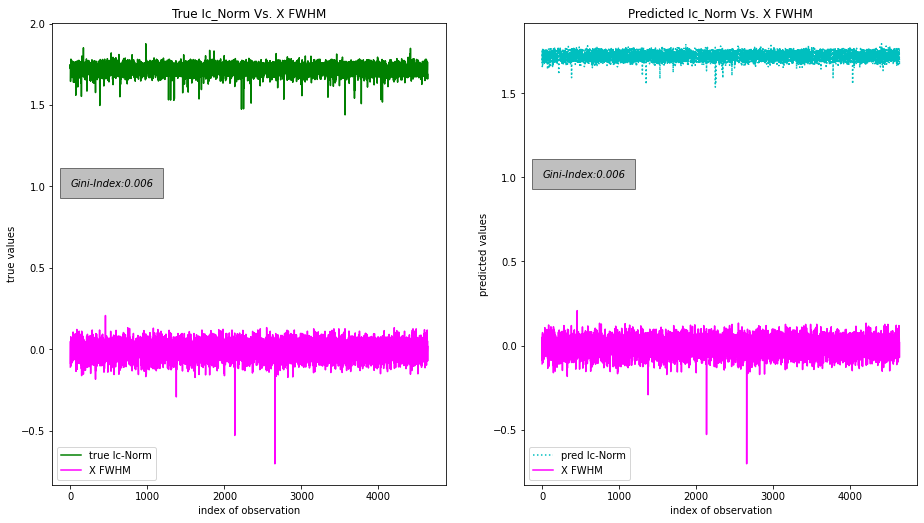

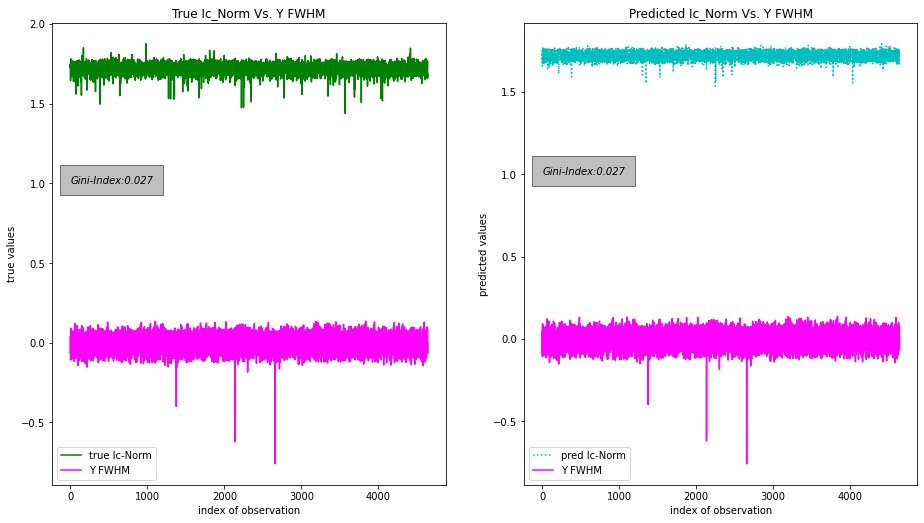

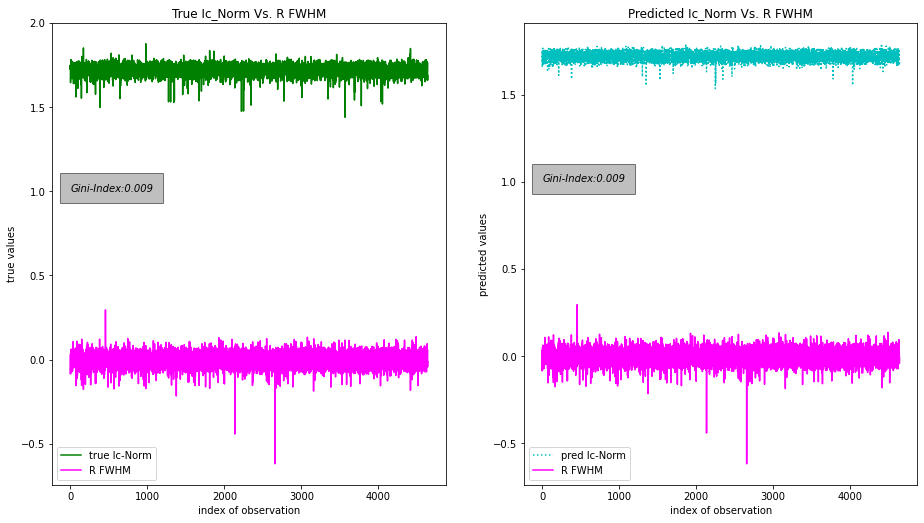

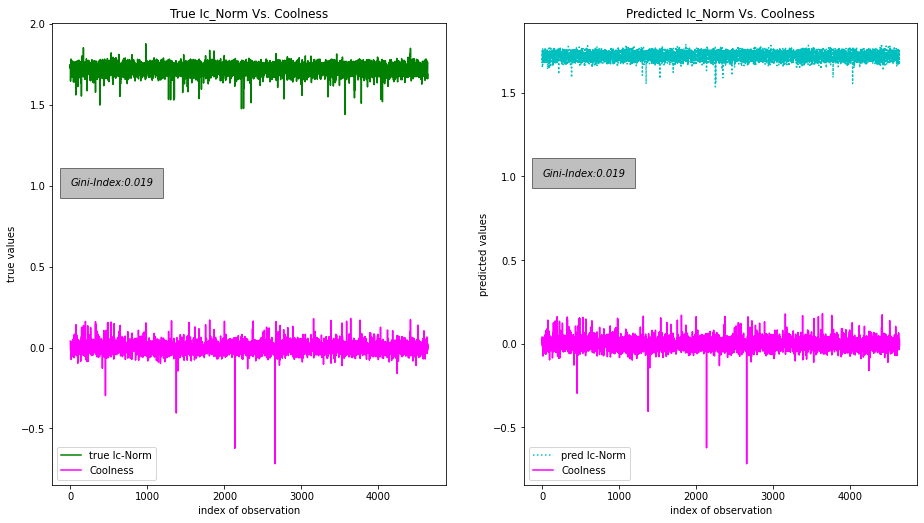

In [20]:

for feature in range(len(name_important_features_rf)):
    f_idx = features_names.index(name_important_features_rf[feature])
    fig = plt.figure(figsize=(15.5, 8.5))
    mean = pld_complete[name_important_features_rf[feature]].mean()
    rng = pld_complete[name_important_features_rf[feature]].to_numpy().ptp()
    
    
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(y_test[lb:ub], 'g', label='true Ic-Norm')
    ax.plot(x_r_test[lb:ub, f_idx], 'magenta', label=name_important_features_rf[feature])
    ax.set_xlabel('index of observation')
    ax.set_ylabel('true values')
    ax.set_title('True Ic_Norm Vs. ' + name_important_features_rf[feature])
    ax.text(1., 1, 'Gini-Index:' + "%.3f" % values_rf_feature_importance[0][feature],
            style='italic', bbox={'facecolor': 'gray', 'alpha': 0.5, 'pad': 10})
    ax.legend()
    
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(y_hat_rf[lb:ub], 'c:', label='pred Ic-Norm')
    ax.plot(x_r_test[lb:ub, f_idx], 'magenta',  label=name_important_features_rf[feature])
    ax.set_xlabel('index of observation')
    ax.set_ylabel('predicted values')
    ax.set_title('Predicted Ic_Norm Vs. ' + name_important_features_rf[feature])
    ax.text(1., 1., 'Gini-Index:' + "%.3f" % values_rf_feature_importance[0][feature],
            style='italic', bbox={'facecolor': 'gray', 'alpha': 0.5, 'pad': 10})
    ax.legend()

plt.show()




**Interpretation:**

- We cannot say much from these figures, so let us invent something else








### GDBoost - Least Square

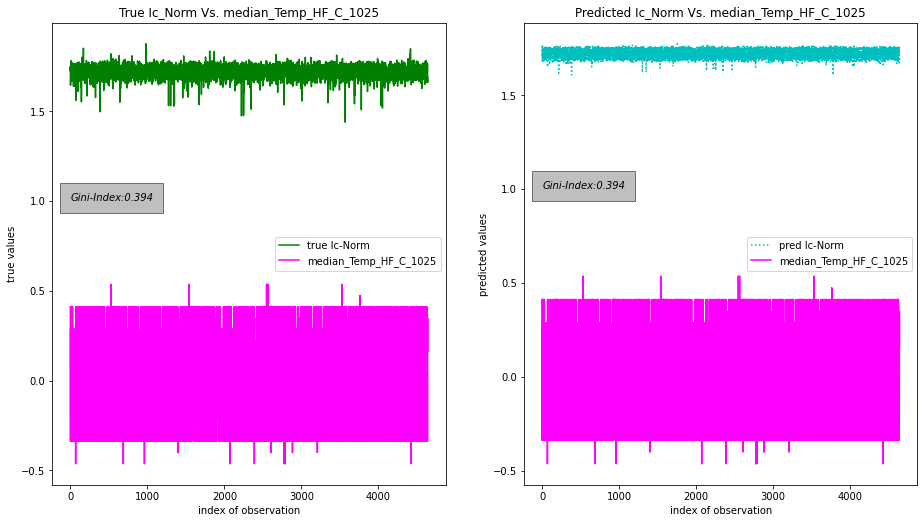

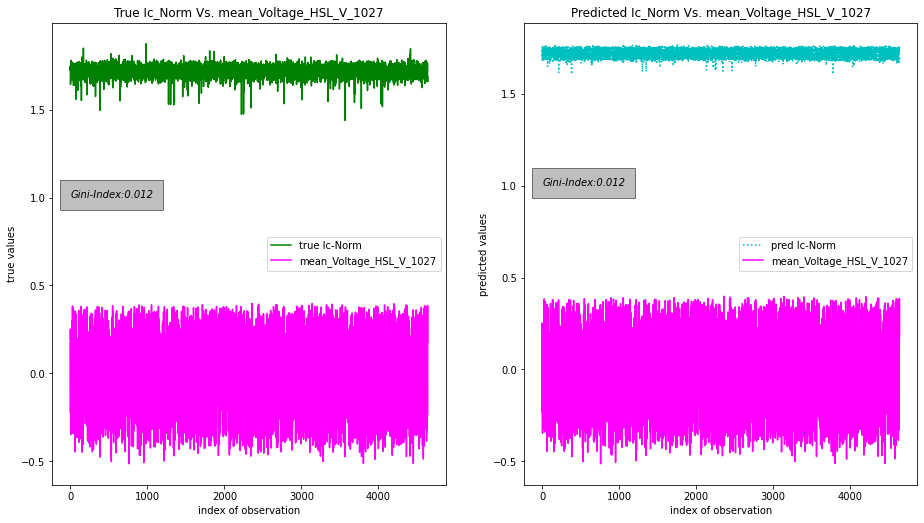

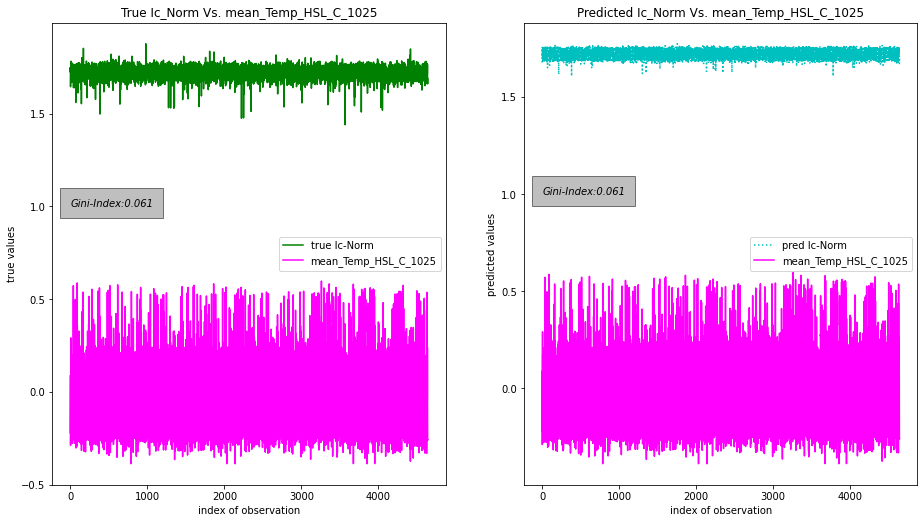

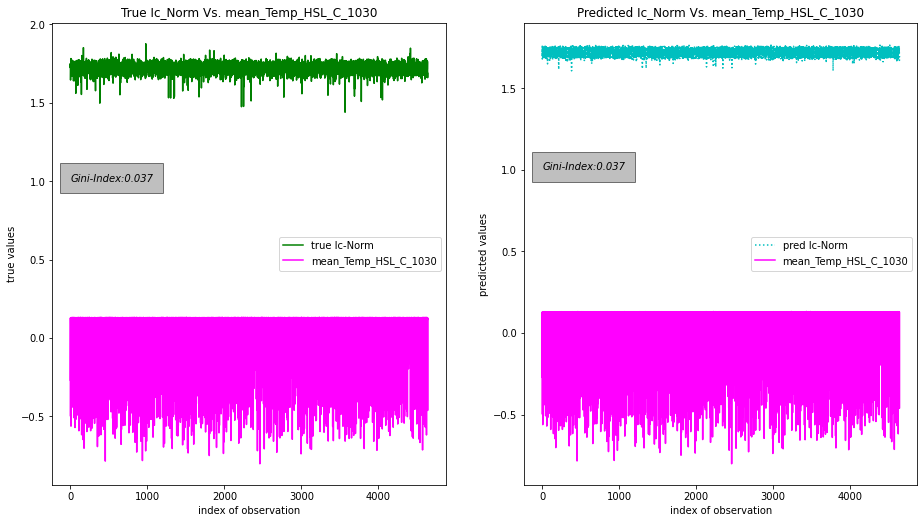

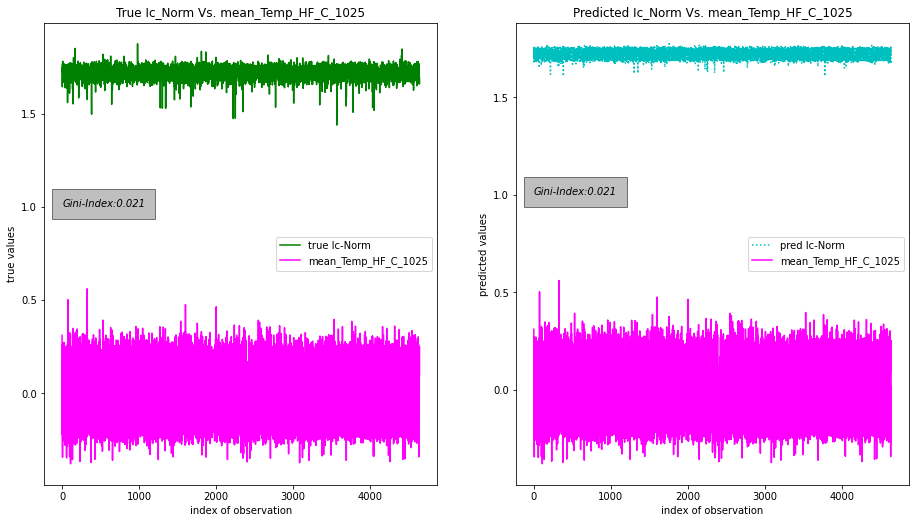

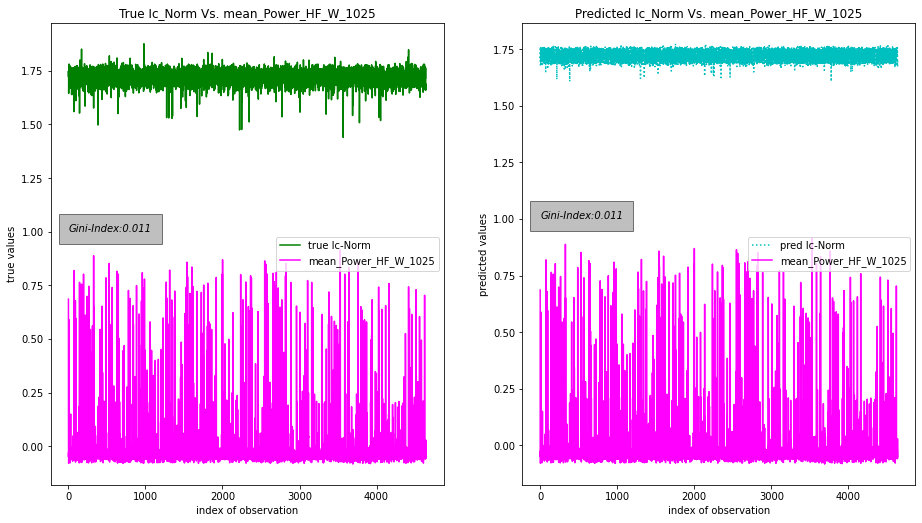

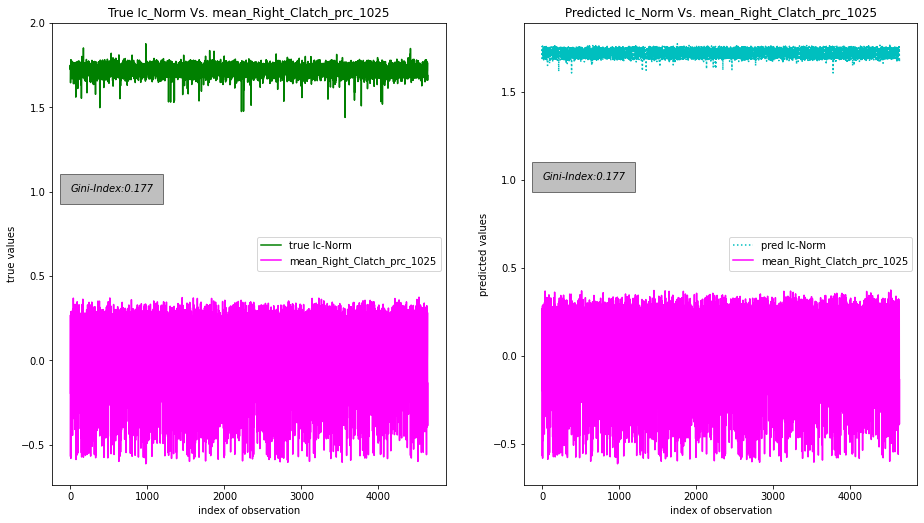

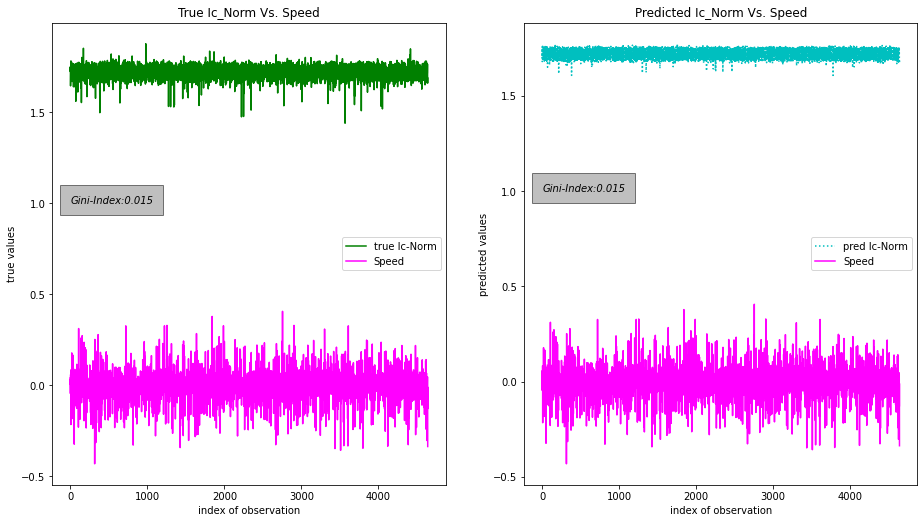

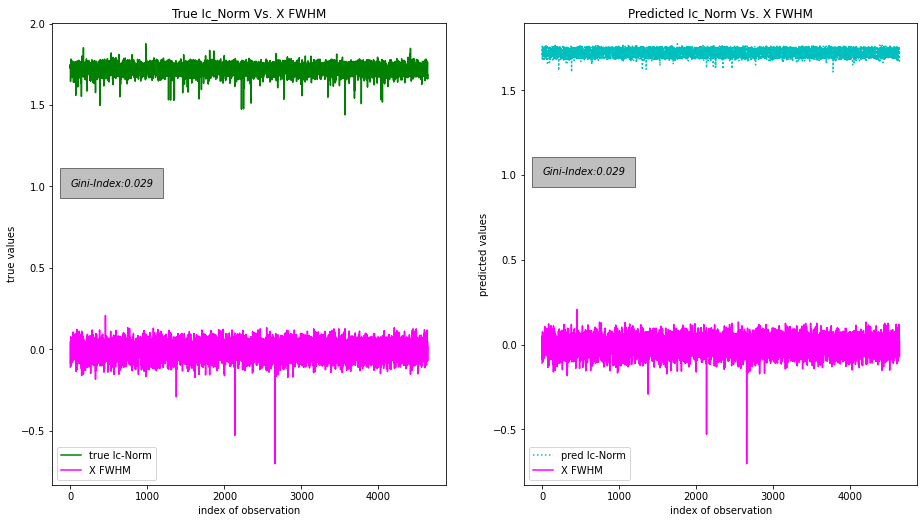

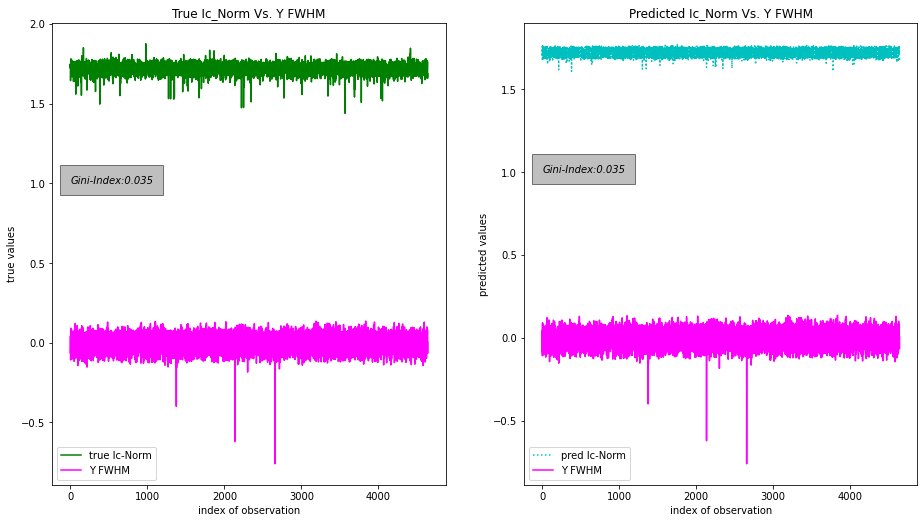

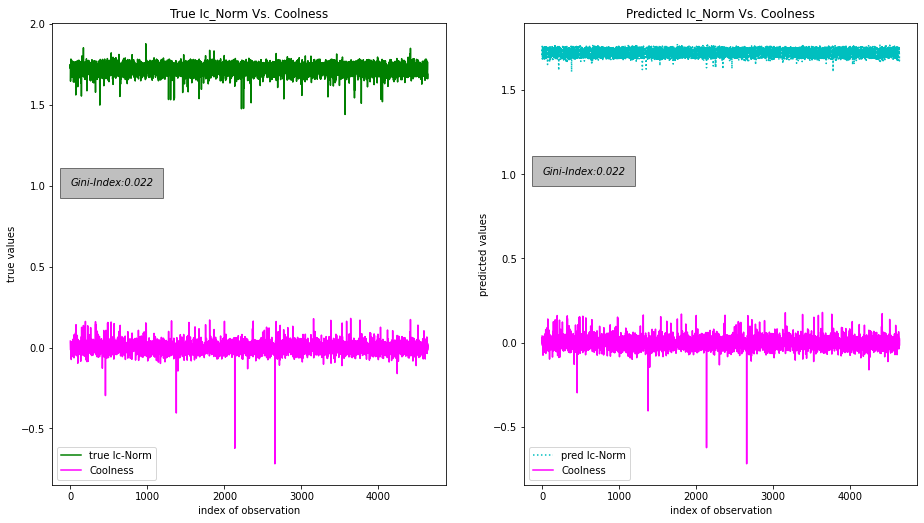

In [21]:

for feature in range(len(name_important_features_gbr_ls)):
    f_idx = features_names.index(name_important_features_gbr_ls[feature])
    fig = plt.figure(figsize=(15.5, 8.5))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(y_test[lb:ub], 'g', label='true Ic-Norm')
    ax.plot(x_r_test[lb:ub, f_idx], 'magenta', label=name_important_features_gbr_ls[feature])
    ax.set_xlabel('index of observation')
    ax.set_ylabel('true values')
    ax.set_title('True Ic_Norm Vs. ' + name_important_features_gbr_ls[feature])
    ax.text(1., 1, 'Gini-Index:' + "%.3f" % values_gbr_ls_feature_importance[0][feature],
            style='italic', bbox={'facecolor': 'gray', 'alpha': 0.5, 'pad': 10})
    ax.legend()
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(y_hat_gbr_ls[lb:ub], 'c:', label='pred Ic-Norm')
    ax.plot(x_r_test[lb:ub, f_idx], 'magenta',  label=name_important_features_gbr_ls[feature])
    ax.set_xlabel('index of observation')
    ax.set_ylabel('predicted values')
    ax.set_title('Predicted Ic_Norm Vs. ' + name_important_features_gbr_ls[feature])
    ax.text(1., 1., 'Gini-Index:' + "%.3f" % values_gbr_ls_feature_importance[0][feature],
            style='italic', bbox={'facecolor': 'gray', 'alpha': 0.5, 'pad': 10})
    ax.legend()

plt.show()


**Interpretation**

- We cannot say much from these figures, so let us invent something else



# Permutation Index: visualization of relation between important features and target values 

In [31]:
pld_complete_range_noICs_noPos = pld_complete_range.loc[:, ~pld_complete_range.columns.isin(['Ic', 'Ic_norm', 'pos'])]
features_names = list(pld_complete_range_noICs_noPos.columns)
lb = 0  # to filter the demonstrations-- index of lower bound >> lowest = 0
ub = 4703  # to filter the demonstrations-- index of upper bound >> highest = n_samples (4703)

### Random Forest 

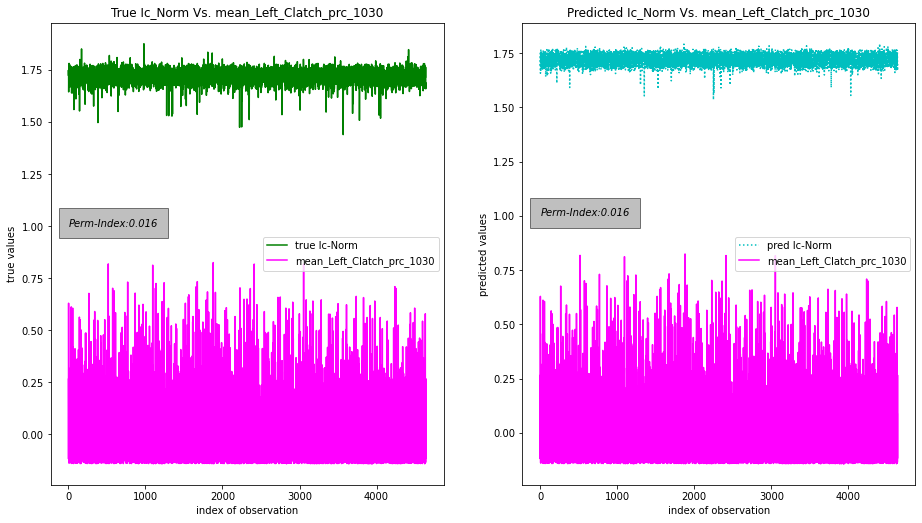

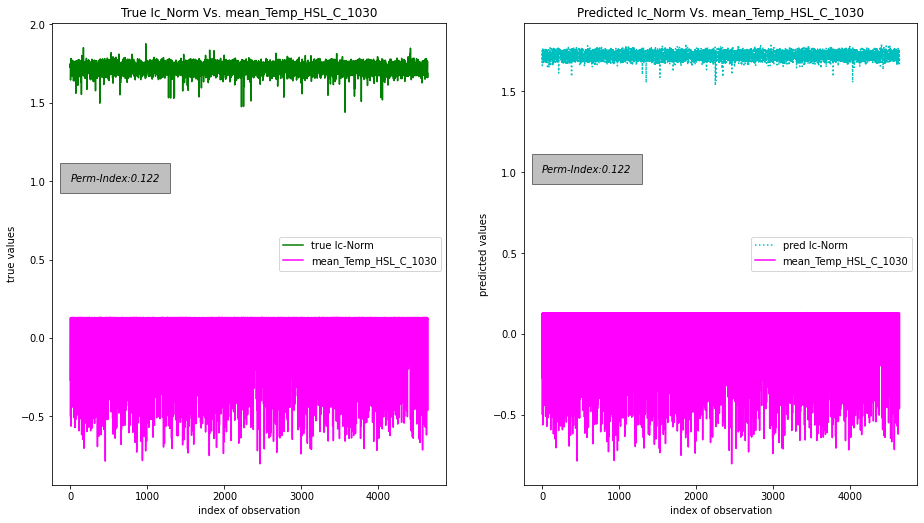

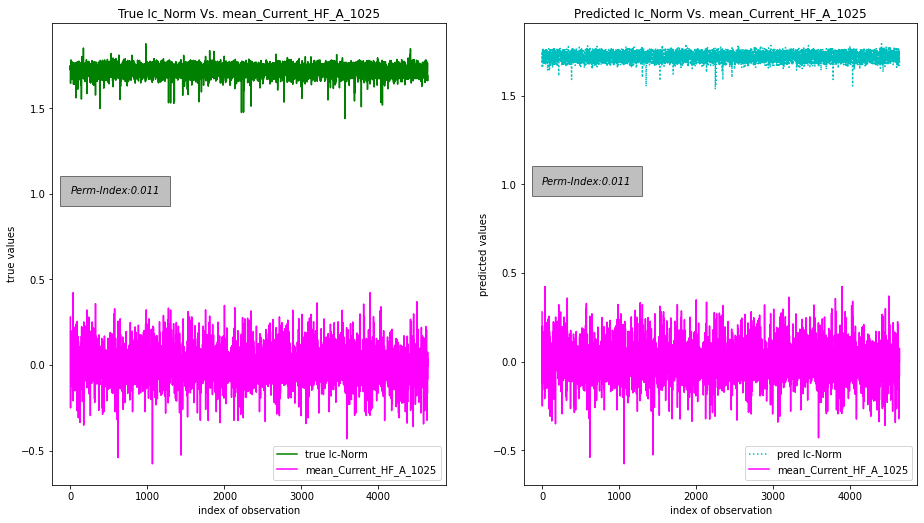

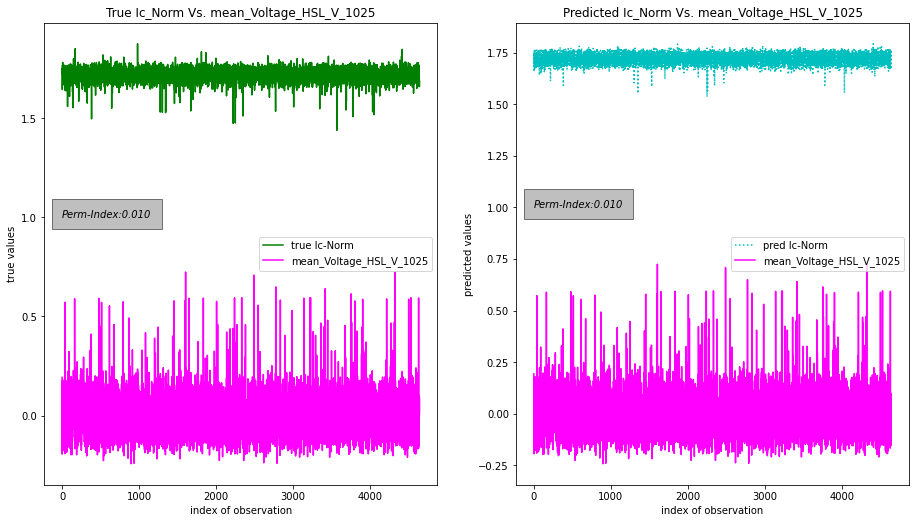

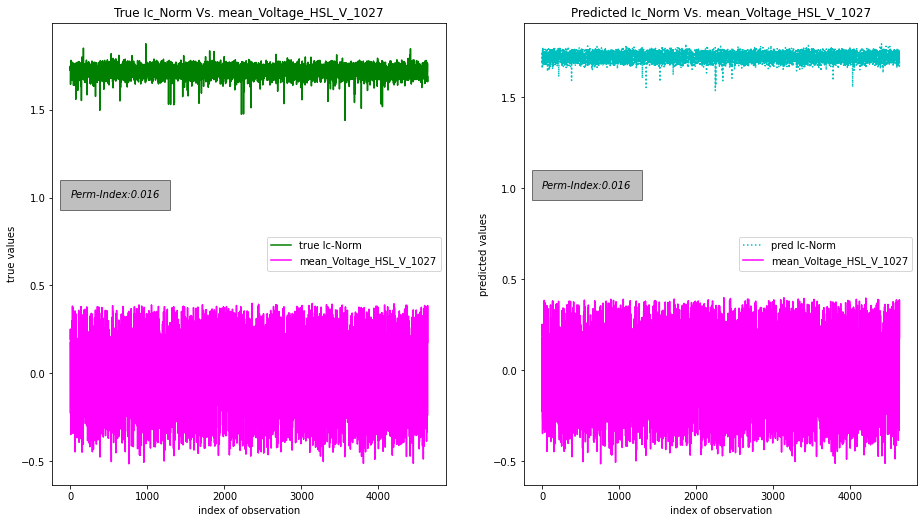

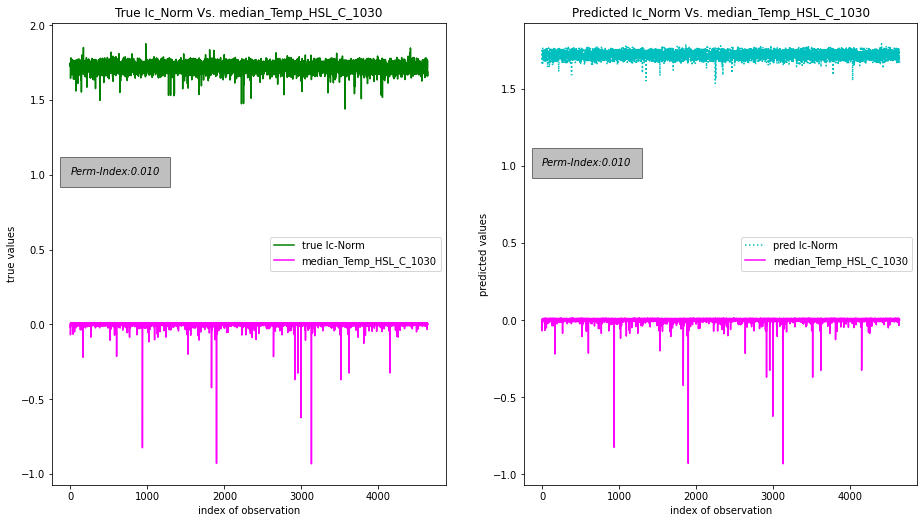

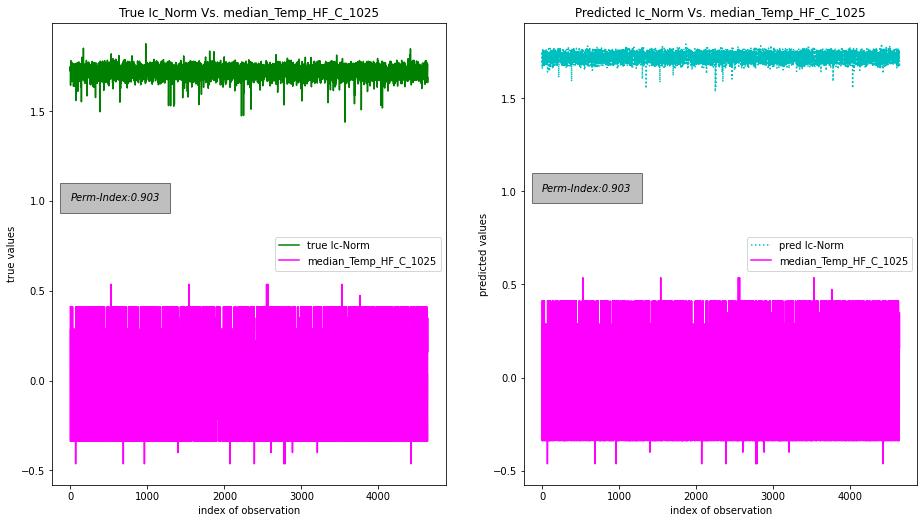

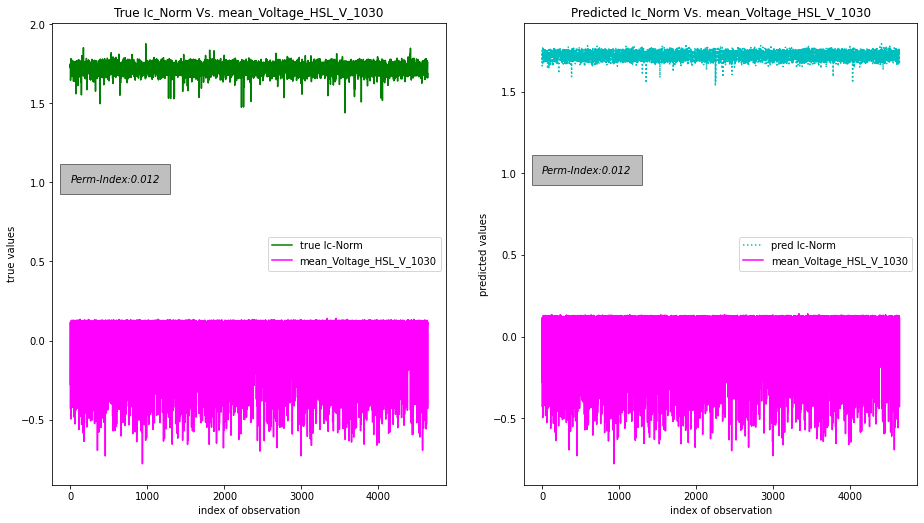

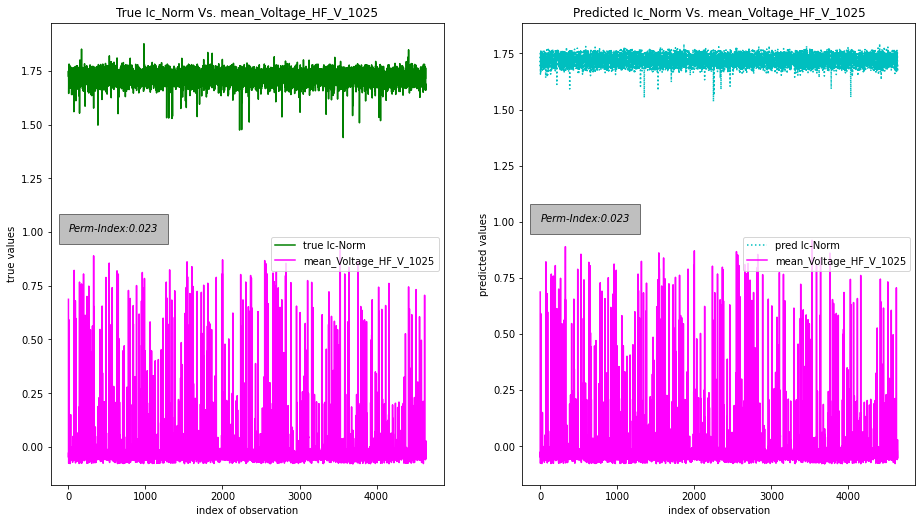

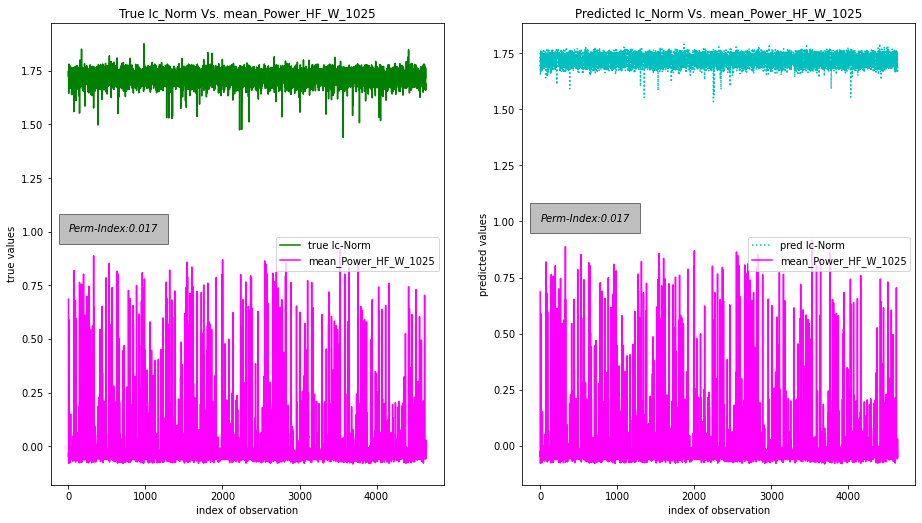

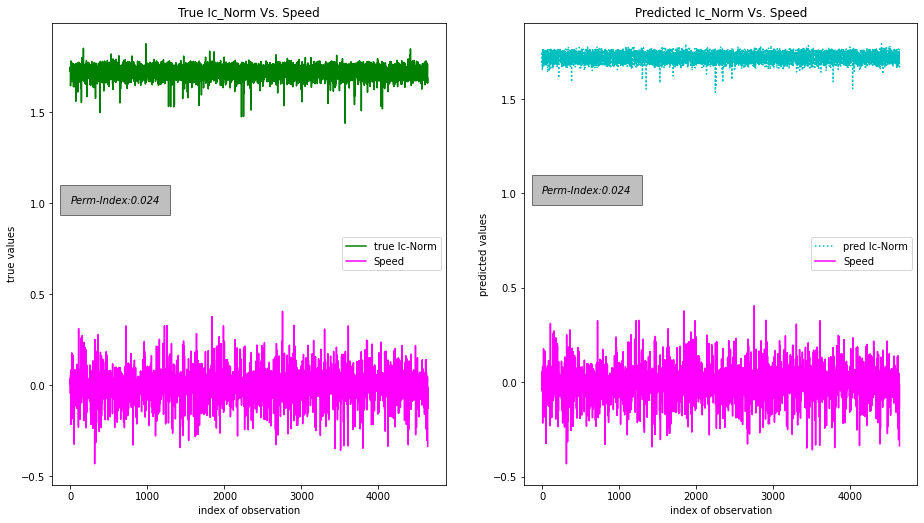

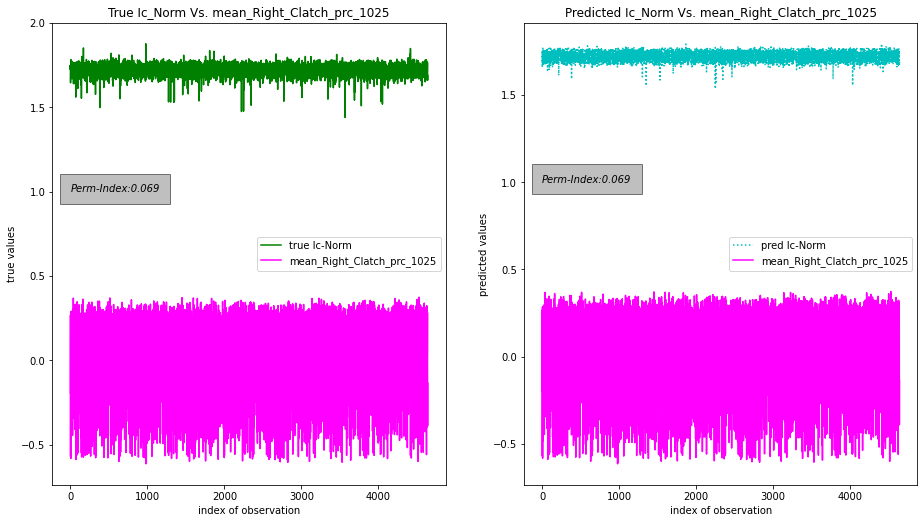

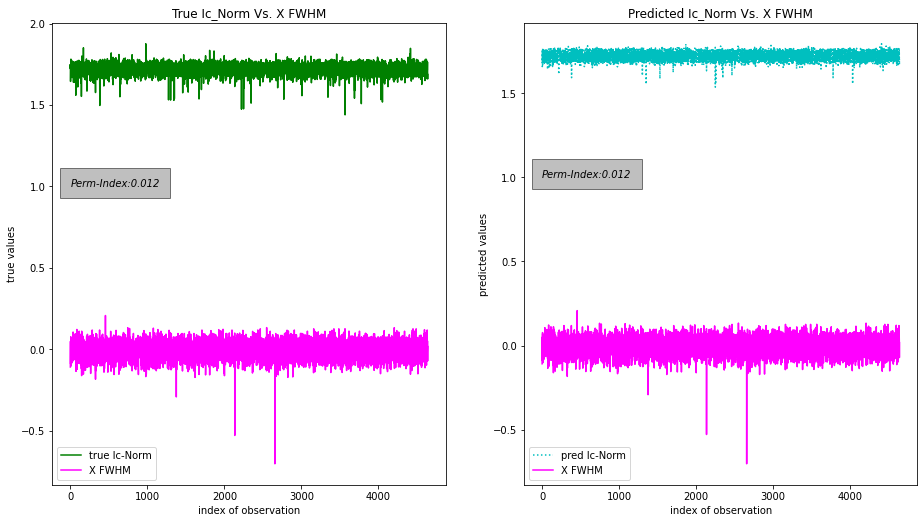

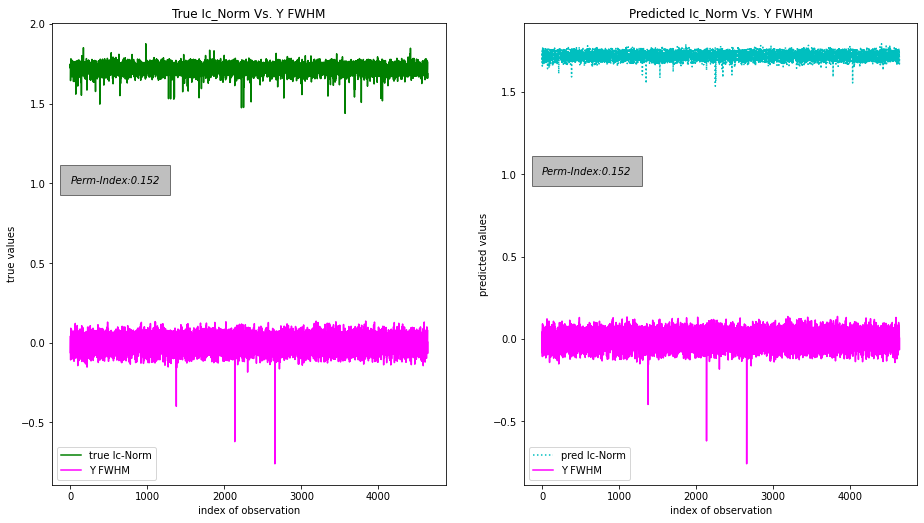

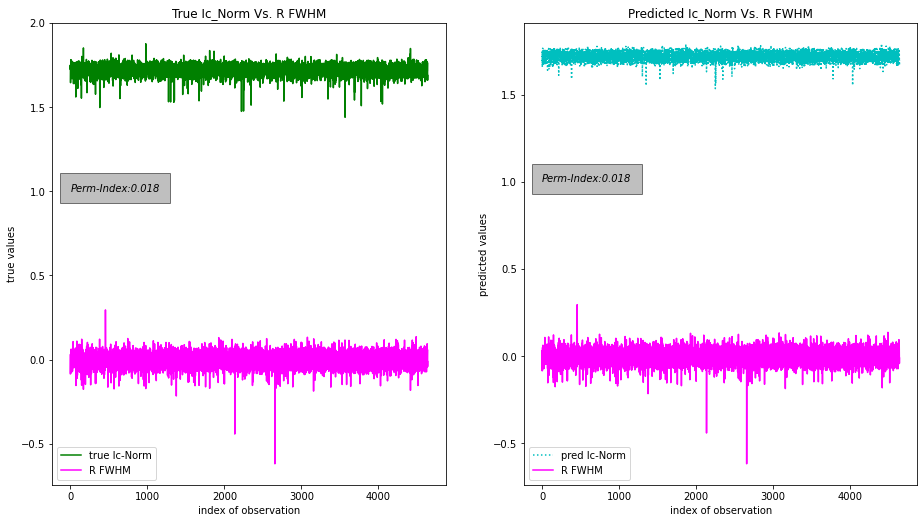

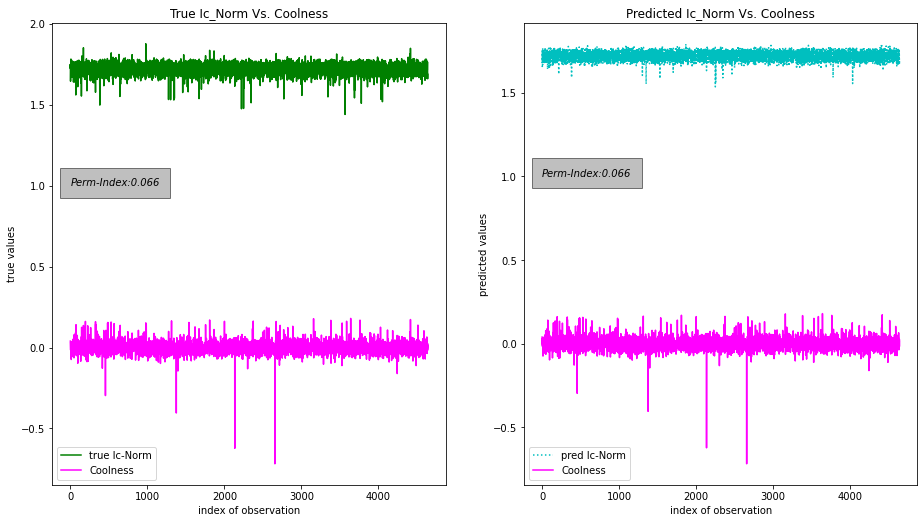

In [32]:

for feature in range(len(name_important_features_rf_permute)):
    f_idx = features_names.index(name_important_features_rf_permute[feature])
    fig = plt.figure(figsize=(15.5, 8.5))
    mean = pld_complete[name_important_features_rf_permute[feature]].mean()
    rng = pld_complete[name_important_features_rf_permute[feature]].to_numpy().ptp()
    
    
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(y_test[lb:ub], 'g', label='true Ic-Norm')
    ax.plot(x_r_test[lb:ub, f_idx], 'magenta', label=name_important_features_rf_permute[feature])
    ax.set_xlabel('index of observation')
    ax.set_ylabel('true values')
    ax.set_title('True Ic_Norm Vs. ' + name_important_features_rf_permute[feature])
    ax.text(1., 1, 'Perm-Index:' + "%.3f" % values_rf_feature_importance_permute[0][feature],
            style='italic', bbox={'facecolor': 'gray', 'alpha': 0.5, 'pad': 10})
    ax.legend()
    
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(y_hat_rf[lb:ub], 'c:', label='pred Ic-Norm')
    ax.plot(x_r_test[lb:ub, f_idx], 'magenta',  label=name_important_features_rf_permute[feature])
    ax.set_xlabel('index of observation')
    ax.set_ylabel('predicted values')
    ax.set_title('Predicted Ic_Norm Vs. ' + name_important_features_rf_permute[feature])
    ax.text(1., 1., 'Perm-Index:' + "%.3f" % values_rf_feature_importance_permute[0][feature],
            style='italic', bbox={'facecolor': 'gray', 'alpha': 0.5, 'pad': 10})
    ax.legend()

plt.show()


**Interpretation**

- We cannot say much from these figures, so let us invent something else


### GDBoost - Least Square

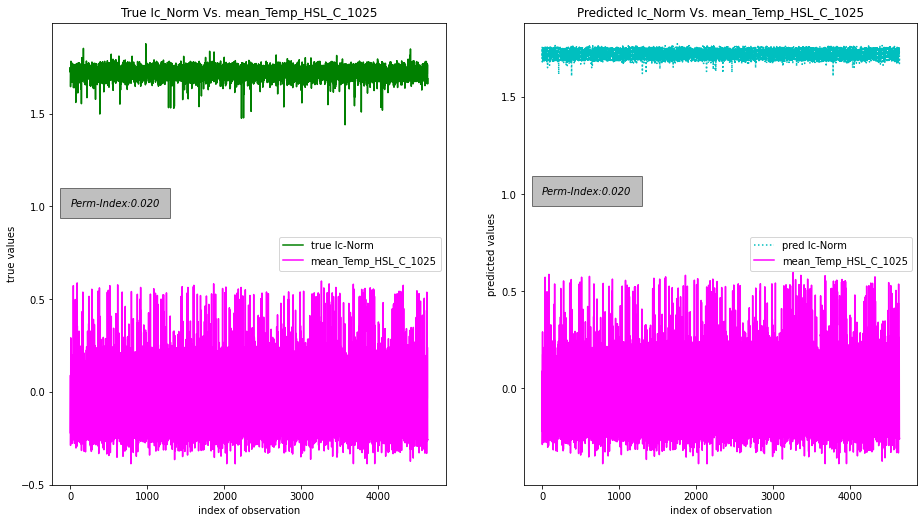

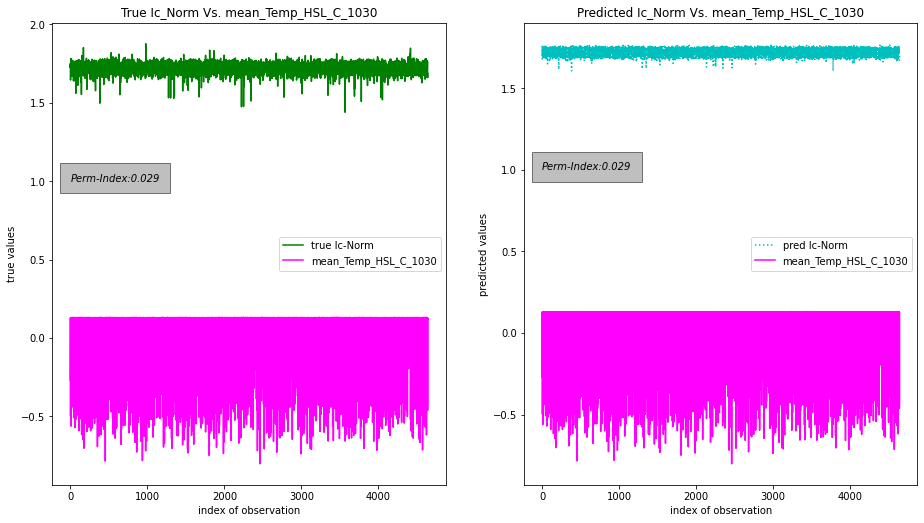

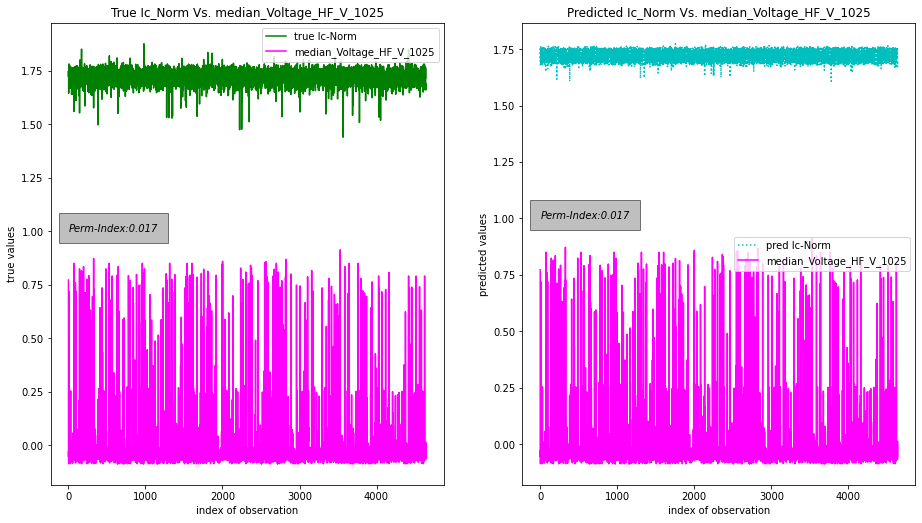

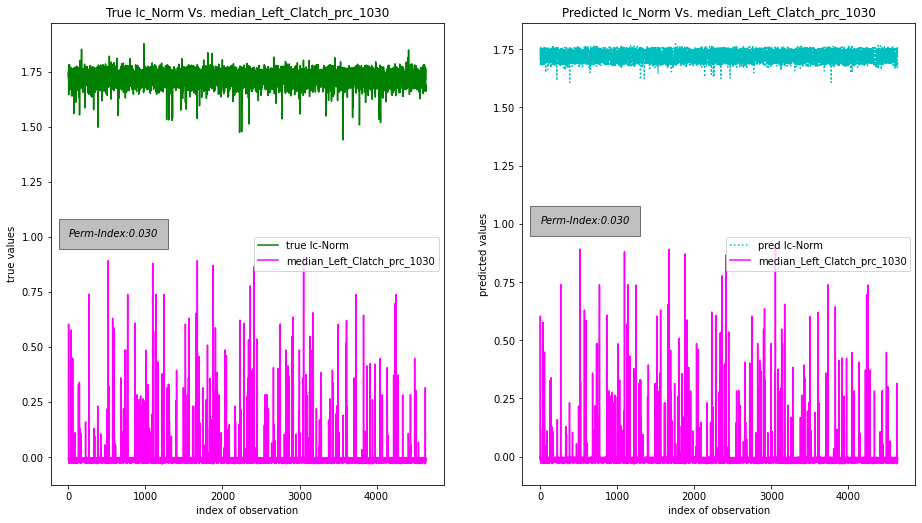

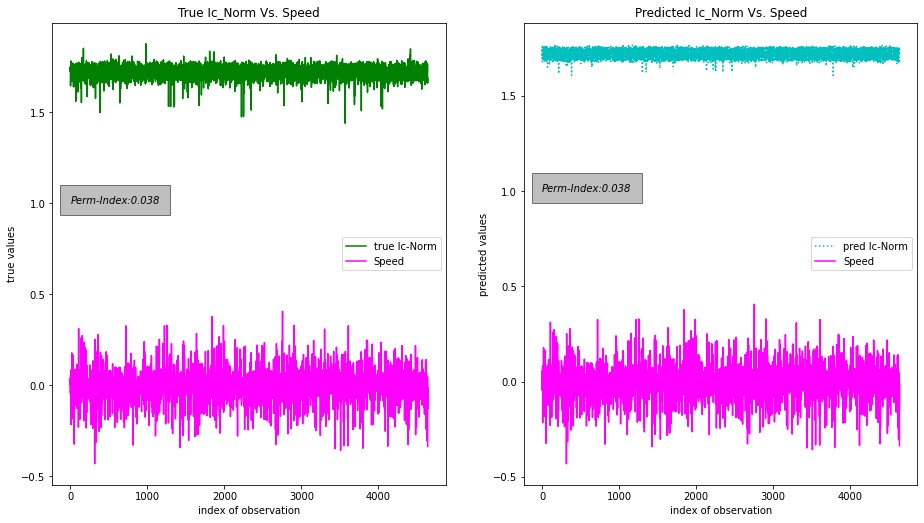

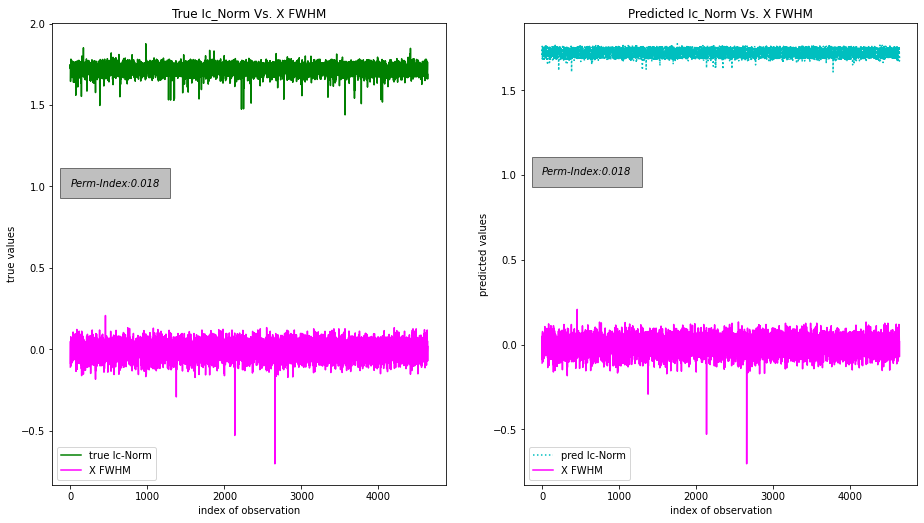

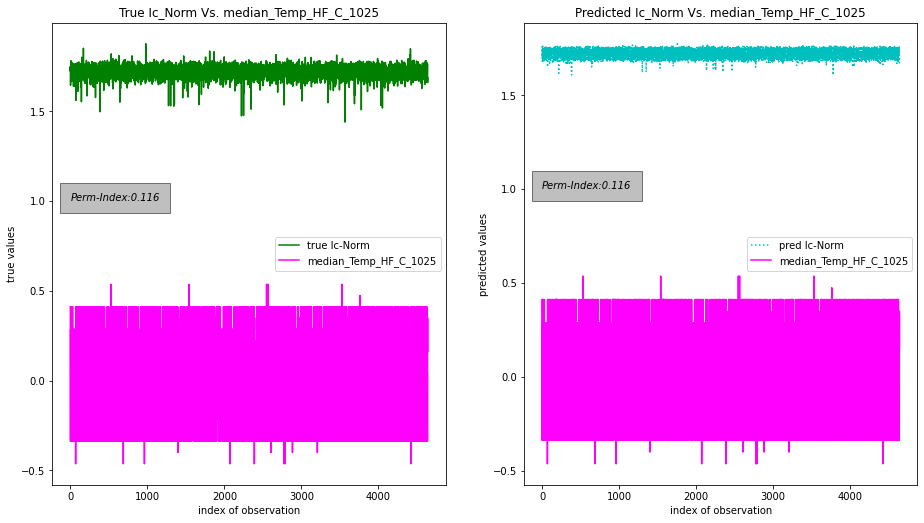

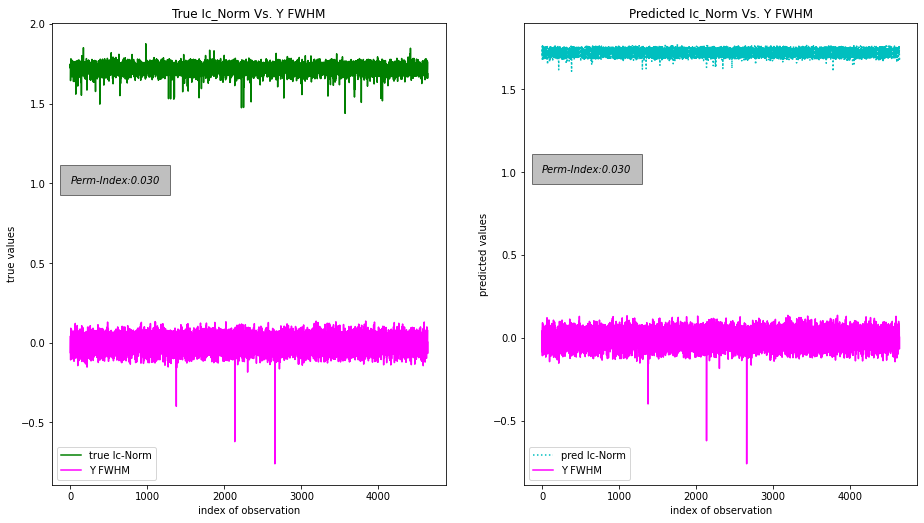

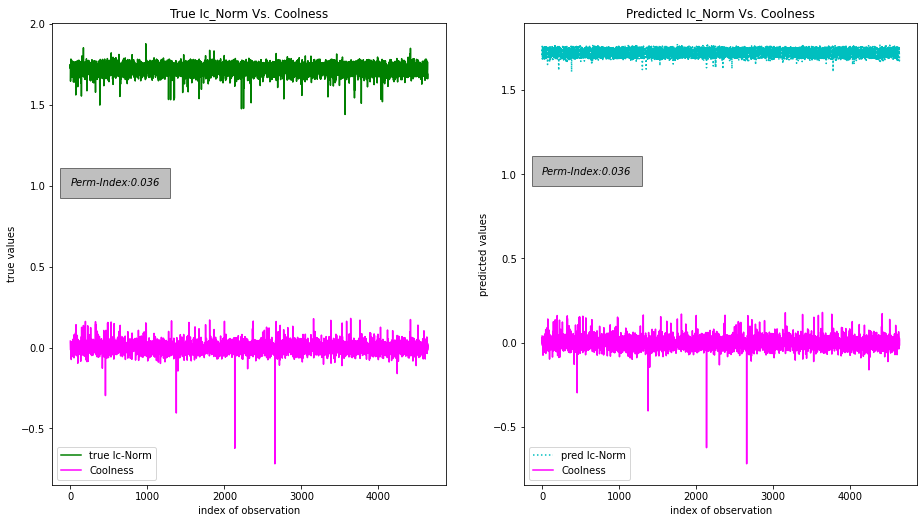

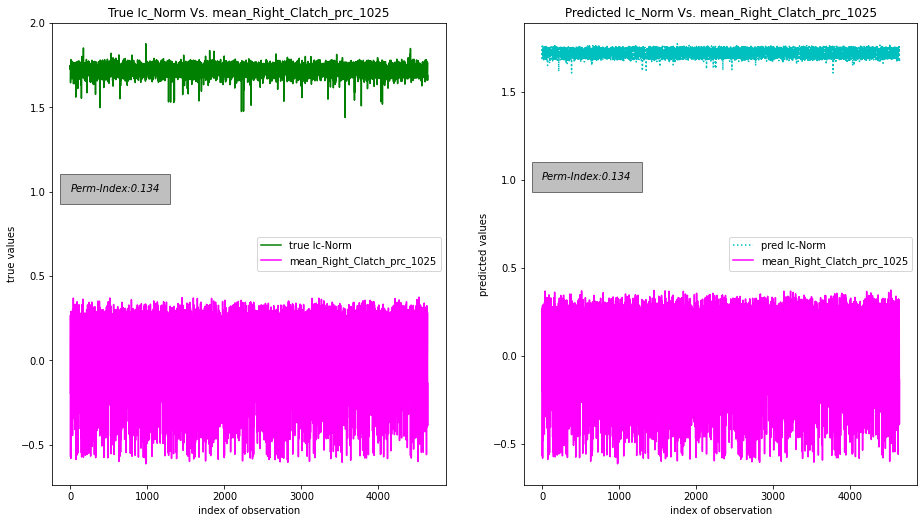

In [33]:

for feature in range(len(name_important_features_gbr_ls_permute)):
    f_idx = features_names.index(name_important_features_gbr_ls_permute[feature])
    fig = plt.figure(figsize=(15.5, 8.5))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(y_test[lb:ub], 'g', label='true Ic-Norm')
    ax.plot(x_r_test[lb:ub, f_idx], 'magenta', label=name_important_features_gbr_ls_permute[feature])
    ax.set_xlabel('index of observation')
    ax.set_ylabel('true values')
    ax.set_title('True Ic_Norm Vs. ' + name_important_features_gbr_ls_permute[feature])
    ax.text(1., 1, 'Perm-Index:' + "%.3f" % values_gbr_ls_feature_importance_permute[0][feature],
            style='italic', bbox={'facecolor': 'gray', 'alpha': 0.5, 'pad': 10})
    ax.legend()
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(y_hat_gbr_ls[lb:ub], 'c:', label='pred Ic-Norm')
    ax.plot(x_r_test[lb:ub, f_idx], 'magenta',  label=name_important_features_gbr_ls_permute[feature])
    ax.set_xlabel('index of observation')
    ax.set_ylabel('predicted values')
    ax.set_title('Predicted Ic_Norm Vs. ' + name_important_features_gbr_ls_permute[feature])
    ax.text(1., 1., 'Perm-Index:' + "%.3f" % values_gbr_ls_feature_importance_permute[0][feature],
            style='italic', bbox={'facecolor': 'gray', 'alpha': 0.5, 'pad': 10})
    ax.legend()

plt.show()


**Interpretation**

- We cannot say much from these figures, so let us invent something else


 ### Another solution to investigate the relationship between the important features and target values


In [46]:
def plot_relationships(data, regressor, important_feature_indices, 
                       importance_feature_names, name_of_importance_method, values_feature_importance):
    

    scaling_ranges = np.arange(-1.05, 1.20, 0.1)

    for index in important_feature_indices:
        fig = plt.figure(figsize=(13.5, 7.5))
        ax = fig.add_subplot(1, 1, 1)
        data_new = np.zeros([data.shape[0], data.shape[1]])
        y_hat_new = []
        feature_name = importance_feature_names[index]
        for s in scaling_ranges:
            data_new[:, :index] = data[:, :index]
            data_new[:, index] = data[:, index]*s
            data_new[:, index+1:] = data[:, index+1:]
            y_hat_new.append((regressor.predict(data_new)/regressor.predict(data)))

        y_hat_new = np.asarray(y_hat_new)

        plt.plot(scaling_ranges, y_hat_new.mean(axis=1), c='k')
        plt.fill_between(scaling_ranges, y_hat_new.mean(axis=1)-y_hat_new.std(axis=1), 
                         y_hat_new.mean(axis=1)+y_hat_new.std(axis=1), 
                         alpha=0.5, color='b')

        ax.text(-1.1, 1., name_of_importance_method + ':' + "%.3f" % values_feature_importance[0][index],
                style='italic', bbox={'facecolor': 'gray', 'alpha': 0.5, 'pad': 10})

        plt.title(feature_name)
        plt.show()

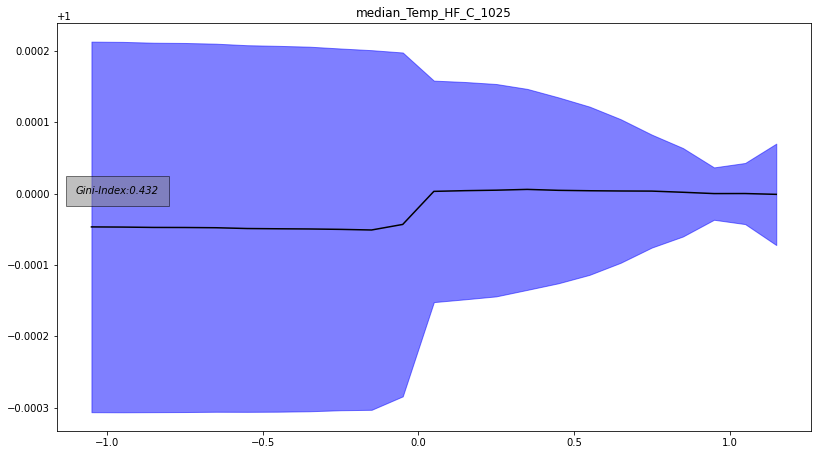

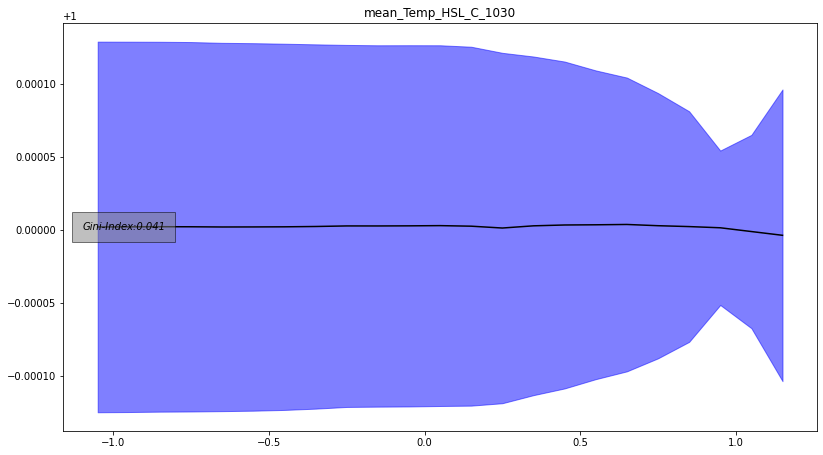

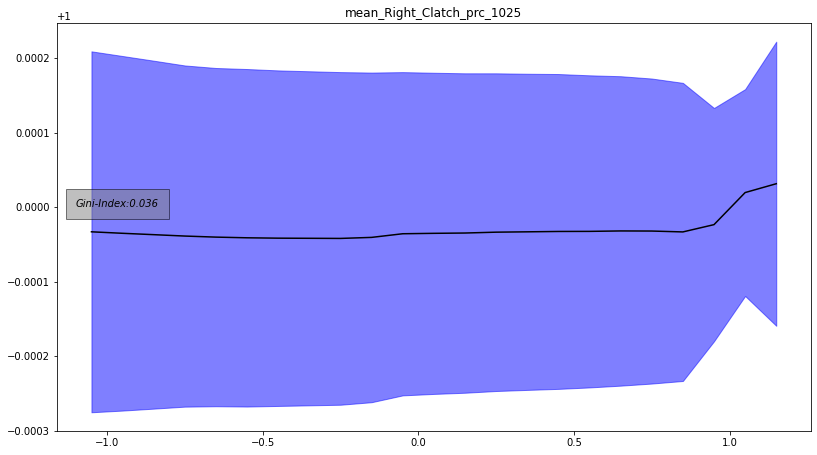

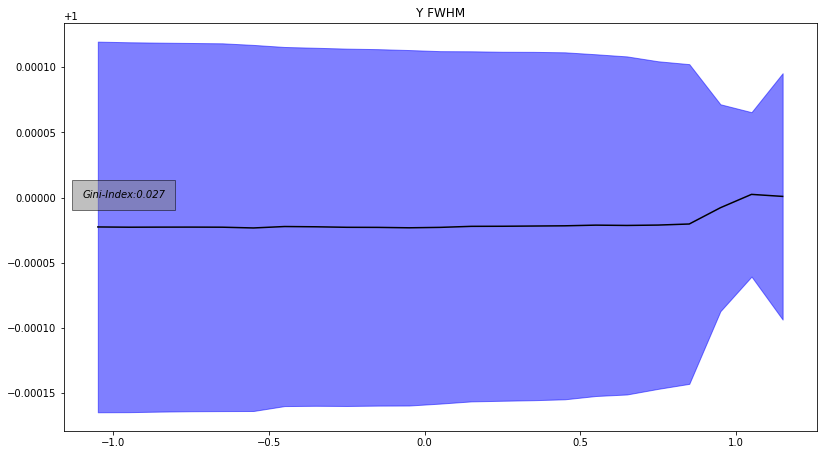

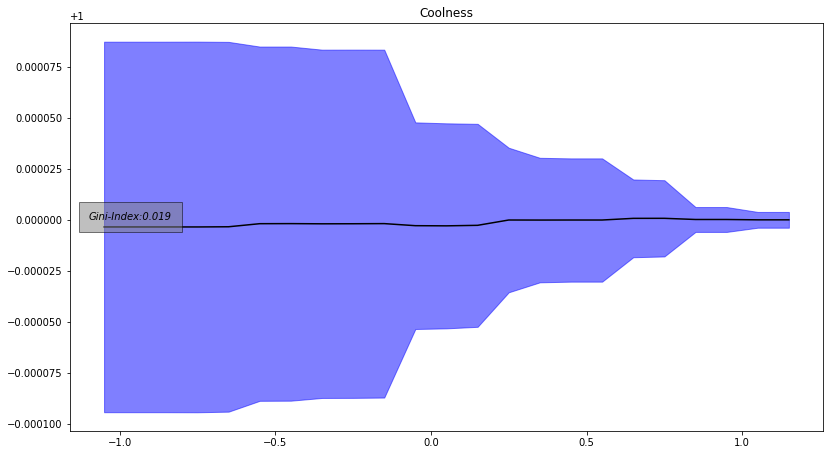

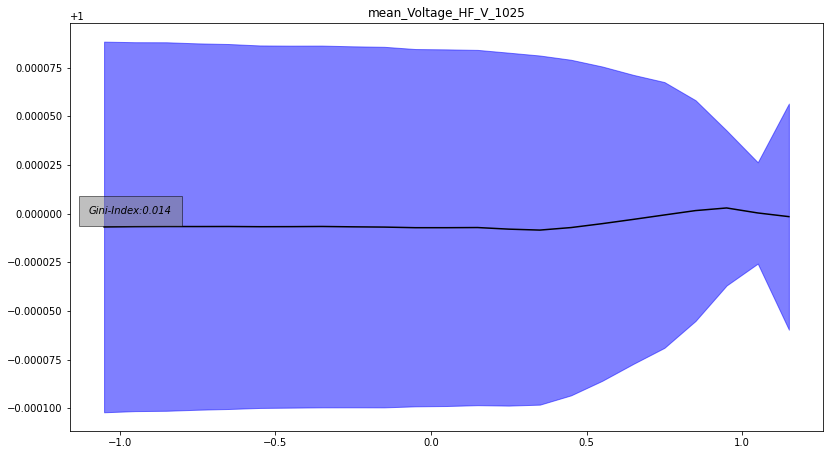

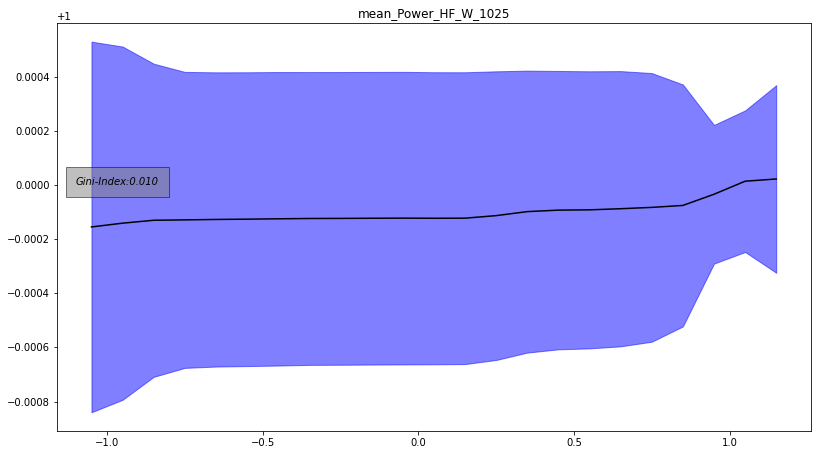

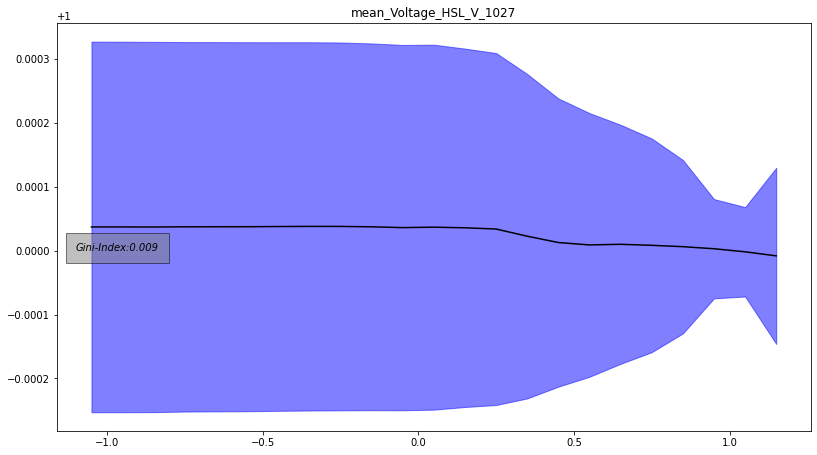

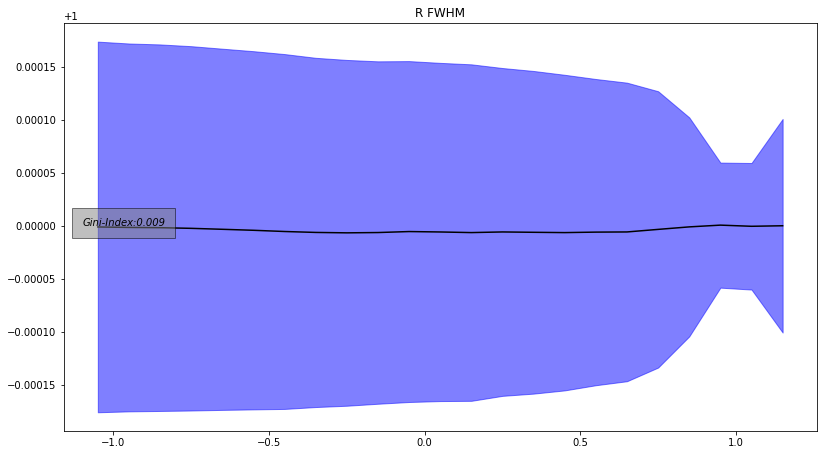

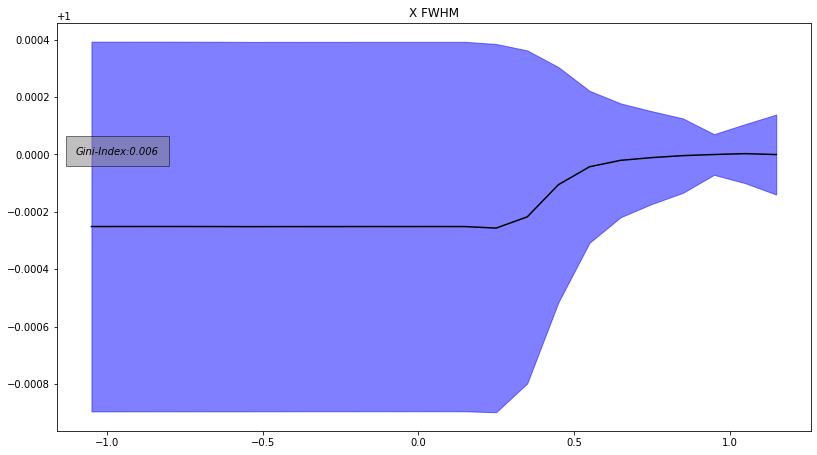

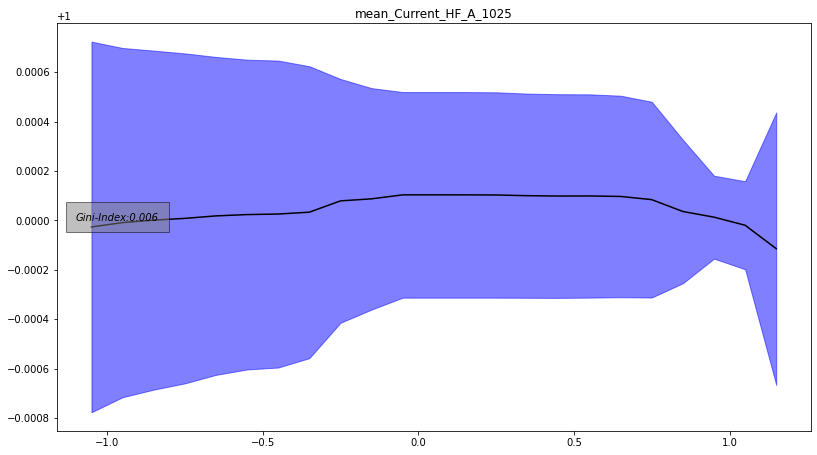

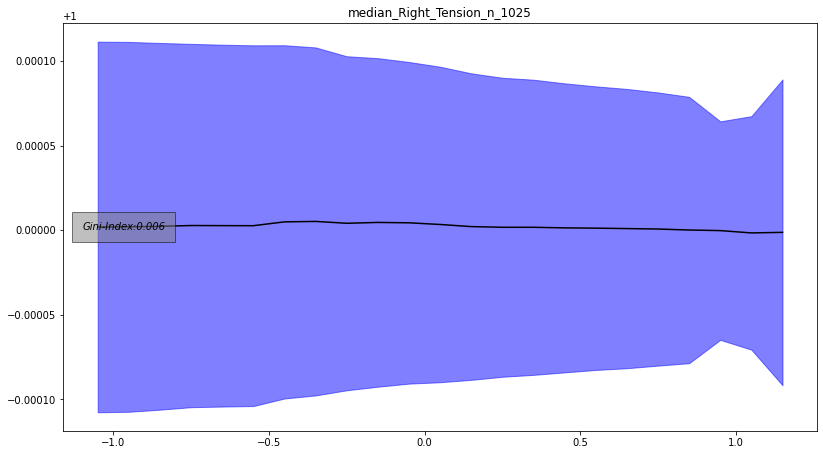

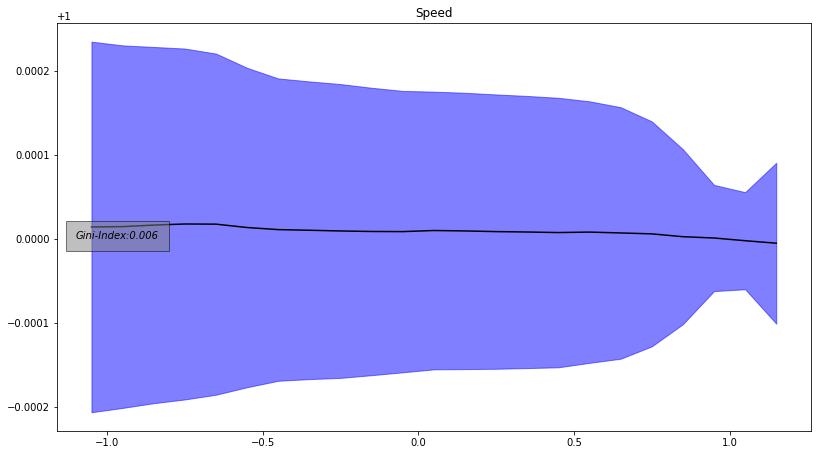

In [47]:
plot_relationships(data=x_r_test, 
                   regressor = rf_reg,
                   important_feature_indices= idx_rf, 
                   importance_feature_names = name_important_features_rf,
                   name_of_importance_method = 'Gini-Index', 
                   values_feature_importance = values_rf_feature_importance
                  )

- non informative and a misleading in my opinion


# Conclusion:

- In this Jupeter notebook we consider **Ic_Norm** as the target value. 
- The **pos** feature is also dropped out.
- The table below conclude this study.
- The best results are high-lighted in bold-face.
- R^2 score:.
    - The closer to unity the better. 
    - The Negative values represent arbitrarily bad values. 
    - Zero represents constant model which predict the expected value of y, disregarding the input features (random predictions)

- The MRAE shows the Mean Relative Absolute Error. The smaller the better.
- The importance of features are determined with:
    - applying Gini-Impurity, the higher the more important and vice-versa (not reported in the table below)
    - permutation method: the higher the more important and vice-versa
    
- Those features which have permutation index higher than a threshold are considered as important features


|   |  MRAE | $R^2$ | Value-Name(1st) | Value-Name(2nd) | Value-Name(3rd) | Value-Name(4th) | Value-Name(5th) |
| --- | --- | --- |---| ---| --- | --- | --- |
|RF Reg.| 0.006(0.000) | 0.773(0.002)| 0.903 median_Temp_HF_C_1025 | 0.152 Y FWHM | 0.122 mean_Temp_HSL_C_1030 |0.069 mean_Right_Clatch_prc_1025 | 0.066 Coolness| 
|GBR-Ls | 0.008(0.000) | 0.660(0.000) |0.134 mean_Right_Clatch_prc_1025 | 0.116 median_Temp_HF_C_1025 | 0.038 Speed | 0.036 Coolness |  0.030 median_Left_Clatch_prc_1030 |


- w.r.t  RF is the winner.

- I recommend providing both regression algorithms with both methods of determining the feature importance. And leave the task of final choice to the taskmaster or a person who is completely aware of the process and these features.






